In [1]:
import gc
gc.collect()

0

In [2]:
from __future__ import print_function
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from numpy import save
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

import time


In C:\Python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.jpeg_quality rcparam was deprecated in Matplo

In [3]:
import sys

sys.path.append("C:/Users/admin/Desktop/IP Paris/MICAS/Cours/910/913 - Deep Learning/Project/")

# Import helper functions
from networks import NeuralNetwork
from optimization.optimizers import StochasticGradientDescent, Adam, RMSprop, Adagrad, Adadelta, NesterovAcceleratedGradient
from networks.loss_functions import CrossEntropy, SquareLoss, CrossEntropy, MSE
from utils.misc import bar_widgets
from networks.layers import Dense, Dropout, Activation, BatchNormalization, Conv2D, Flatten

from helpers.helper import *
from helpers.processing import *

from Channel.parameters import *
from Channel.transmitor import *
from Channel.modulator import *
from Channel.channel import *
from Channel.equalizer import *
from Channel.demodulator import *
from Channel.detector import *
from nnet_Generator.NNetGenerator import *

Using TensorFlow backend.


In [ ]:
# np.load is lazy
d300K = np.load('../data/data_4_300K_P2.6e-2.npz')
d100K = np.load('../data/data_5_100K_P2.6e-2.npz')
d90K = np.load('../data/data_1_90K_P6e-2_P5e-2_P2.6e-2.npz')

In [6]:
d160K = np.load('../data/modulation/160K_XY.npz')

In [5]:
d80K = np.load('../data/modulation/80K_XY_16_symb.npz')

#### Unfortunately, I can't train with such huge dataset due to hardware limitations...

In [50]:
X = np.concatenate([d300K['X'], d100K['X'], d90K['X']])
y = np.concatenate([d300K['y'], d100K['y'], d90K['y']])

MemoryError: Unable to allocate 4.58 GiB for an array with shape (307200000,) and data type complex128

In [ ]:
from sklearn.utils import shuffle

# if we are training on 1 and 16 symbols, I take only a sample of the dataset (no more than 80k), to ensure having
# a mix of both, I shuffle the two arrays.
# Must ensure the indexes remains the same to not mix up signals.
X_all, y_all = shuffle(X_all, y_all, random_state=0)

X = X_all[:80000,:]
y = y_all[:80000,:]

In [11]:
t1 = time.time()
# if scaling=True, we are using min-max scaler
df = prepareDataFrame(X, y, scaling=False)
#df.to_csv("../data/data_90K.csv.gz", index=False, compression="gzip")
t2 = time.time()
print("Toral time to prepare the dataframe is : ", t2-t1, " seconds.")

  0%|▏                                                                            | 179/80000 [00:00<01:39, 804.62it/s]


 [INFO] {fromComplexToReal} runing...


  0%|                                                                              | 97/80000 [00:00<01:23, 960.42it/s]

 [INFO] {fromComplexToReal} vect_real.shape :  (80000, 2048)

 [INFO] {fromComplexToReal} runing...


100%|██████████████████████████████████████████████████████████████████████████| 80000/80000 [01:19<00:00, 1011.25it/s]


 [INFO] {fromComplexToReal} vect_real.shape :  (80000, 2048)
{prepareDataFrame} df_.shape :  (80000, 4096)
Toral time to prepare the dataframe is :  171.6568706035614  seconds.


In [12]:
X.shape

(80000, 1024)

In [13]:
#X = df.iloc[:, 2048:4096]
#y = df.iloc[:, 0:2048]
n_samples, n_features = X.shape
n_hidden = 512

In [14]:
withReshape = True
ts = 0.25
X_train, X_test, y_train, y_test = prepareTrainAndTestData(df, withReshape, ts)

[INFO] - {prepareTrainAndTestData} converting from pandas to numpy...
[INFO] train and test data are ready.
X.shape :  (80000, 2048)
y.shape :  (80000, 2048)
X_train.shape :  (60000, 2048, 1)
y_train.shape :  (60000, 2048, 1)
X_test.shape :  (20000, 2048, 1)
y_test.shape :  (20000, 2048, 1)


In [17]:
X_train = np.squeeze(X_train)
X_test = np.squeeze(X_test)
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

In [19]:
x_tr = X_train[0:100,:]
x_te = X_test[110:115,:]
y_tr = y_train[0:100,:]
y_te = y_test[110:115,:]

In [20]:
x_tr = np.squeeze(x_tr)
x_te = np.squeeze(x_te)
y_tr = np.squeeze(y_tr)
y_te = np.squeeze(y_te)

# MLP model

* In this part **we will first model the equalizer**, the neural network should take as input the distorted signal and try to recover the modulated signal with a low loss (and also a **low BER**).


* Next we will try out the **end-to-end bit-to-bits model** that takes a source of a distorted signal and try to recover the original one with a high accuracy i.e a **low BER**.

# I. Modeling the Equalizer


In [35]:
#-------------------------------------------------------------------------------------------------#

def get_prepared_mod_data(ts= 0.25, withReshape = True):
    
    
    d80K = np.load('../data/modulation/80K_XY_16_symb.npz')
    X = d80K['X']
    y = d80K['y']

    t1 = time.time()
    df = prepareDataFrame(X, y)
    t2 = time.time()
    
    print("[INFO] Total time to prepare the dataframe is : ", t2-t1, " seconds.")

    X_train, X_test, y_train, y_test = prepareTrainAndTestData(df, withReshape, ts)
    
    print("[INFO] Squeezing datas...")
    X_train = np.squeeze(X_train)
    X_test = np.squeeze(X_test)
    y_train = np.squeeze(y_train)
    y_test = np.squeeze(y_test)
    
    return X_train, X_test, y_train, y_test

#-------------------------------------------------------------------------------------------------#

def evals(model, X_test, y_test, index_pred, opti, train_err, val_err, nsymbols=16):
    
    # Training and validation error plot
    n = len(train_err)
    training, = plt.plot(range(n), train_err, label="Training Error")
    validation, = plt.plot(range(n), val_err, label="Validation Error")
    plt.legend(handles=[training, validation])
    plt.title("Error Plot using "+str(opti))
    plt.ylabel('Error')
    plt.xlabel('Iterations')
    plt.show()
    
    y_pred = model.predict(X_test[index_pred])
    
    plt.title("Predicted Signal")
    plt.plot(np.squeeze(np.abs(y_pred)))
    plt.show()
    
    plt.title("Predicted Signal vs Original")
    plt.plot(np.squeeze(np.abs(y_pred)), label="prediction")
    plt.plot(np.squeeze(np.abs(y_test[index_pred])), label="original")
    plt.legend()
    plt.show()
    
    evaluate_ber(y_pred, y_test, index_pred, nsymbols)
    
    return y_pred

#-------------------------------------------------------------------------------------------------#

def evaluate_ber(y_pred, y_test, index_pred, nsymbols):
    
    nLayers = 500                         # Number of Layers of the Generative network
    y_ori = y_test[index_pred]
    # Initialize parameters
    parameters = Parameters(nsymbols=nsymbols, nLayers=nLayers)
    # Initialize the Equalizer
    equalizer = Equalizer()
    # Initialize the Demodulator
    demodulator = Demodulator()
    # Initialize the Transmitor
    transmitor = Transmitor()
    # Initialize the Detector
    detector = Detector(transmitor)
    
    # propagation & equalization.
    q0t = fromRealToComplex(y_pred)    
    #qzt, qzf = channel.channel(parameters.t, q0t, parameters.z, parameters.sigma2, parameters.B) 
    qzt = q0t
    qzte, qzfe = equalizer.equalize(parameters.t, qzt, parameters.z) # equalized output
    # demodulation
    shat = demodulator.demod(parameters.t, parameters.dt, qzte, parameters.B, parameters.n)

    # detection
    stilde, indexes = detector.detector(shat, parameters.M)
    bhat = detector.symbols_to_bit(indexes, parameters.M)
    y_ori = y_ori.reshape(1,-1)
    
    # propagation & equalization.
    q0t = fromRealToComplex(y_ori)
    qzt = q0t
    qzte, qzfe = equalizer.equalize(parameters.t, qzt, parameters.z) # equalized output
    # demodulation
    s = demodulator.demod(parameters.t, parameters.dt, qzte, parameters.B, parameters.n)

    # detection
    stilde, indexes = detector.detector(s, parameters.M)
    b = detector.symbols_to_bit(indexes, parameters.M)

    
    ser = detector.ser(s, stilde)  # symbol error rate
    ber = detector.ber(b, bhat)  # bit error rate
    
    print("b : ", b)
    print("bhat : ", bhat)
    print("ber : ", ber)
    print("ser : ", ser)

#-------------------------------------------------------------------------------------------------#

In [5]:
X_train, X_test, y_train, y_test = get_prepared_mod_data()

  0%|                                                                              | 89/80000 [00:00<01:29, 888.23it/s]


 [INFO] {fromComplexToReal} runing...


  0%|                                                                            | 116/80000 [00:00<01:09, 1155.84it/s]

 [INFO] {fromComplexToReal} vect_real.shape :  (80000, 2048)

 [INFO] {fromComplexToReal} runing...


100%|███████████████████████████████████████████████████████████████████████████| 80000/80000 [01:28<00:00, 902.35it/s]


 [INFO] {fromComplexToReal} vect_real.shape :  (80000, 2048)
{prepareDataFrame} df_.shape :  (80000, 4096)
[INFO] Total time to prepare the dataframe is :  193.01562547683716  seconds.
[INFO] - {prepareTrainAndTestData} converting from pandas to numpy...
[INFO] train and test data are ready.
X.shape :  (80000, 2048)
y.shape :  (80000, 2048)
X_train.shape :  (60000, 2048, 1)
y_train.shape :  (60000, 2048, 1)
X_test.shape :  (20000, 2048, 1)
y_test.shape :  (20000, 2048, 1)
[INFO] Squeezing datas...


In [6]:
X_train.shape

(60000, 2048)

# Rectangular Networks

## Square Loss
###  Adam

In [9]:
optimizer = Adam()
opti = 'Adam'
n_features = 2048
n_output = 2048
rect_mlp = NeuralNetwork(optimizer=optimizer,
                        loss=SquareLoss,
                        validation_data=(X_test, y_test))

In [10]:
rect_mlp.add(Dense(2048, input_shape=(n_features,)))
rect_mlp.add(Activation('elu'))
rect_mlp.add(Dropout(0.25))
rect_mlp.add(BatchNormalization())


rect_mlp.add(Dense(1024))
rect_mlp.add(Activation('elu'))
rect_mlp.add(Dropout(0.25))
rect_mlp.add(BatchNormalization())

rect_mlp.add(Dense(n_output))
rect_mlp.add(Activation('elu'))

print ()
rect_mlp.summary(name="MLP Rect 2048*1024*2048")


+-------------------------+
| MLP Rect 2048*1024*2048 |
+-------------------------+
Input Shape: (2048,)
+--------------------+------------+--------------+
| Layer Type         | Parameters | Output Shape |
+--------------------+------------+--------------+
| Dense              | 4196352    | (2048,)      |
| Activation (ELU)   | 0          | (2048,)      |
| Dropout            | 0          | (2048,)      |
| BatchNormalization | 4096       | (2048,)      |
| Dense              | 2098176    | (1024,)      |
| Activation (ELU)   | 0          | (1024,)      |
| Dropout            | 0          | (1024,)      |
| BatchNormalization | 2048       | (1024,)      |
| Dense              | 2099200    | (2048,)      |
| Activation (ELU)   | 0          | (2048,)      |
+--------------------+------------+--------------+
Total Parameters: 8399872



In [28]:
num_epochs = 20
batch_size = 256

In [ ]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", num_epochs)
train_err_rect, val_err_rect = rect_mlp.fit(X_train, y_train, num_epochs, batch_size)

[INFO] Batch size :  256
[INFO] Training epochs number :  20


[INFO] Training loss on epoch  1  :  0.31688
[INFO] Validation loss on epoch  1  :  0.30394
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  2  :  0.30044
[INFO] Validation loss on epoch  2  :  0.29573
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  3  :  0.29390
[INFO] Validation loss on epoch  3  :  0.29145
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  4  :  0.28937
[INFO] Validation loss on epoch  4  :  0.28830
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  5  :  0.28571
[INFO] Validation loss on epoch  5  :  0.28632
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  6  :  0.28278
[INFO] Validation loss on epoch  6  :  0.28488
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  7  :  0.28031
[INFO] Validation loss on epoch  7  :  0.28389
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  8  :  0.27820
[INFO] Validation loss on epoch  8  :  0.28304
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  9  :  0.27632
[INFO] Validation loss on epoch  9  :  0.28243
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  10  :  0.27447
[INFO] Validation loss on epoch  10  :  0.28184
-------------------------------------------------------------------------------


### Let's train on more epochs

* It took 8h to train on my laptop.

In [38]:
optimizer = Adam()
opti = 'Adam'
n_features = 2048
n_output = 2048
rect_mlp = NeuralNetwork(optimizer=optimizer,
                        loss=SquareLoss,
                        validation_data=(X_test, y_test))

In [39]:
rect_mlp.add(Dense(2048, input_shape=(n_features,)))
rect_mlp.add(Activation('selu'))
rect_mlp.add(Dropout(0.25))
rect_mlp.add(BatchNormalization())


rect_mlp.add(Dense(1024))
rect_mlp.add(Activation('selu'))
rect_mlp.add(Dropout(0.25))
rect_mlp.add(BatchNormalization())

rect_mlp.add(Dense(n_output))
rect_mlp.add(Activation('selu'))

print ()
rect_mlp.summary(name="MLP")


+-----+
| MLP |
+-----+
Input Shape: (2048,)
+--------------------+------------+--------------+
| Layer Type         | Parameters | Output Shape |
+--------------------+------------+--------------+
| Dense              | 4196352    | (2048,)      |
| Activation (SELU)  | 0          | (2048,)      |
| Dropout            | 0          | (2048,)      |
| BatchNormalization | 4096       | (2048,)      |
| Dense              | 2098176    | (1024,)      |
| Activation (SELU)  | 0          | (1024,)      |
| Dropout            | 0          | (1024,)      |
| BatchNormalization | 2048       | (1024,)      |
| Dense              | 2099200    | (2048,)      |
| Activation (SELU)  | 0          | (2048,)      |
+--------------------+------------+--------------+
Total Parameters: 8399872



In [40]:
num_epochs = 200
batch_size = 256

In [41]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", num_epochs)
train_err_rect, val_err_rect = rect_mlp.fit(X_train, y_train, num_epochs, batch_size)

[INFO] Batch size :  256
[INFO] Training epochs number :  200


[INFO] Training loss on epoch  1  :  0.31625
[INFO] Validation loss on epoch  1  :  0.32026
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  2  :  0.26499
[INFO] Validation loss on epoch  2  :  0.26046
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  3  :  0.25415
[INFO] Validation loss on epoch  3  :  0.25062
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  4  :  0.24794
[INFO] Validation loss on epoch  4  :  0.24631
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  5  :  0.24327
[INFO] Validation loss on epoch  5  :  0.24321
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  6  :  0.23934
[INFO] Validation loss on epoch  6  :  0.24031
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  7  :  0.23613
[INFO] Validation loss on epoch  7  :  0.23838
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  8  :  0.23308
[INFO] Validation loss on epoch  8  :  0.23644
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  9  :  0.23072
[INFO] Validation loss on epoch  9  :  0.23510
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  10  :  0.22821
[INFO] Validation loss on epoch  10  :  0.23403
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  11  :  0.22615
[INFO] Validation loss on epoch  11  :  0.23289
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  12  :  0.22403
[INFO] Validation loss on epoch  12  :  0.23194
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  13  :  0.22201
[INFO] Validation loss on epoch  13  :  0.23120
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  14  :  0.22025
[INFO] Validation loss on epoch  14  :  0.23036
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  15  :  0.21850
[INFO] Validation loss on epoch  15  :  0.22954
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  16  :  0.21670
[INFO] Validation loss on epoch  16  :  0.22886
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  17  :  0.21491
[INFO] Validation loss on epoch  17  :  0.22808
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  18  :  0.21330
[INFO] Validation loss on epoch  18  :  0.22754
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  19  :  0.21196
[INFO] Validation loss on epoch  19  :  0.22716
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  20  :  0.21045
[INFO] Validation loss on epoch  20  :  0.22667
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  21  :  0.20898
[INFO] Validation loss on epoch  21  :  0.22637
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  22  :  0.20765
[INFO] Validation loss on epoch  22  :  0.22603
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  23  :  0.20615
[INFO] Validation loss on epoch  23  :  0.22556
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  24  :  0.20504
[INFO] Validation loss on epoch  24  :  0.22506
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  25  :  0.20366
[INFO] Validation loss on epoch  25  :  0.22503
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  26  :  0.20242
[INFO] Validation loss on epoch  26  :  0.22476
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  27  :  0.20108
[INFO] Validation loss on epoch  27  :  0.22431
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  28  :  0.19994
[INFO] Validation loss on epoch  28  :  0.22402
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  29  :  0.19869
[INFO] Validation loss on epoch  29  :  0.22383
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  30  :  0.19741
[INFO] Validation loss on epoch  30  :  0.22355
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  31  :  0.19658
[INFO] Validation loss on epoch  31  :  0.22339
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  32  :  0.19515
[INFO] Validation loss on epoch  32  :  0.22336
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  33  :  0.19386
[INFO] Validation loss on epoch  33  :  0.22318
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  34  :  0.19347
[INFO] Validation loss on epoch  34  :  0.22290
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  35  :  0.19178
[INFO] Validation loss on epoch  35  :  0.22281
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  36  :  0.19092
[INFO] Validation loss on epoch  36  :  0.22289
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  37  :  0.19029
[INFO] Validation loss on epoch  37  :  0.22281
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  38  :  0.18897
[INFO] Validation loss on epoch  38  :  0.22234
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  39  :  0.18768
[INFO] Validation loss on epoch  39  :  0.22255
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  40  :  0.18711
[INFO] Validation loss on epoch  40  :  0.22246
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  41  :  0.18613
[INFO] Validation loss on epoch  41  :  0.22220
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  42  :  0.18507
[INFO] Validation loss on epoch  42  :  0.22223
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  43  :  0.18425
[INFO] Validation loss on epoch  43  :  0.22213
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  44  :  0.18324
[INFO] Validation loss on epoch  44  :  0.22191
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  45  :  0.18271
[INFO] Validation loss on epoch  45  :  0.22190
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  46  :  0.18156
[INFO] Validation loss on epoch  46  :  0.22181
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  47  :  0.18061
[INFO] Validation loss on epoch  47  :  0.22182
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  48  :  0.17969
[INFO] Validation loss on epoch  48  :  0.22197
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  49  :  0.17925
[INFO] Validation loss on epoch  49  :  0.22200
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  50  :  0.17818
[INFO] Validation loss on epoch  50  :  0.22195
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  51  :  0.17704
[INFO] Validation loss on epoch  51  :  0.22169
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  52  :  0.17632
[INFO] Validation loss on epoch  52  :  0.22175
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  53  :  0.17542
[INFO] Validation loss on epoch  53  :  0.22169
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  54  :  0.17477
[INFO] Validation loss on epoch  54  :  0.22169
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  55  :  0.17415
[INFO] Validation loss on epoch  55  :  0.22200
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  56  :  0.17314
[INFO] Validation loss on epoch  56  :  0.22142
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  57  :  0.17239
[INFO] Validation loss on epoch  57  :  0.22173
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  58  :  0.17143
[INFO] Validation loss on epoch  58  :  0.22199
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  59  :  0.17104
[INFO] Validation loss on epoch  59  :  0.22165
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  60  :  0.17018
[INFO] Validation loss on epoch  60  :  0.22171
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  61  :  0.16909
[INFO] Validation loss on epoch  61  :  0.22197
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  62  :  0.16854
[INFO] Validation loss on epoch  62  :  0.22201
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  63  :  0.16792
[INFO] Validation loss on epoch  63  :  0.22185
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  64  :  0.16742
[INFO] Validation loss on epoch  64  :  0.22154
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  65  :  0.16634
[INFO] Validation loss on epoch  65  :  0.22183
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  66  :  0.16577
[INFO] Validation loss on epoch  66  :  0.22186
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  67  :  0.16462
[INFO] Validation loss on epoch  67  :  0.22191
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  68  :  0.16460
[INFO] Validation loss on epoch  68  :  0.22174
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  69  :  0.16341
[INFO] Validation loss on epoch  69  :  0.22180
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  70  :  0.16304
[INFO] Validation loss on epoch  70  :  0.22176
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  71  :  0.16261
[INFO] Validation loss on epoch  71  :  0.22207
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  72  :  0.16209
[INFO] Validation loss on epoch  72  :  0.22164
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  73  :  0.16092
[INFO] Validation loss on epoch  73  :  0.22203
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  74  :  0.16043
[INFO] Validation loss on epoch  74  :  0.22177
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  75  :  0.15961
[INFO] Validation loss on epoch  75  :  0.22175
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  76  :  0.15908
[INFO] Validation loss on epoch  76  :  0.22184
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  77  :  0.15857
[INFO] Validation loss on epoch  77  :  0.22219
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  78  :  0.15813
[INFO] Validation loss on epoch  78  :  0.22211
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  79  :  0.15698
[INFO] Validation loss on epoch  79  :  0.22190
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  80  :  0.15643
[INFO] Validation loss on epoch  80  :  0.22215
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  81  :  0.15586
[INFO] Validation loss on epoch  81  :  0.22199
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  82  :  0.15533
[INFO] Validation loss on epoch  82  :  0.22230
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  83  :  0.15499
[INFO] Validation loss on epoch  83  :  0.22210
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  84  :  0.15420
[INFO] Validation loss on epoch  84  :  0.22202
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  85  :  0.15376
[INFO] Validation loss on epoch  85  :  0.22212
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  86  :  0.15314
[INFO] Validation loss on epoch  86  :  0.22218
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  87  :  0.15267
[INFO] Validation loss on epoch  87  :  0.22241
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  88  :  0.15183
[INFO] Validation loss on epoch  88  :  0.22225
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  89  :  0.15156
[INFO] Validation loss on epoch  89  :  0.22235
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  90  :  0.15067
[INFO] Validation loss on epoch  90  :  0.22230
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  91  :  0.15014
[INFO] Validation loss on epoch  91  :  0.22234
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  92  :  0.14970
[INFO] Validation loss on epoch  92  :  0.22228
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  93  :  0.14932
[INFO] Validation loss on epoch  93  :  0.22252
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  94  :  0.14880
[INFO] Validation loss on epoch  94  :  0.22231
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  95  :  0.14812
[INFO] Validation loss on epoch  95  :  0.22260
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  96  :  0.14749
[INFO] Validation loss on epoch  96  :  0.22253
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  97  :  0.14731
[INFO] Validation loss on epoch  97  :  0.22256
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  98  :  0.14654
[INFO] Validation loss on epoch  98  :  0.22268
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  99  :  0.14617
[INFO] Validation loss on epoch  99  :  0.22276
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  100  :  0.14563
[INFO] Validation loss on epoch  100  :  0.22276
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  101  :  0.14522
[INFO] Validation loss on epoch  101  :  0.22259
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  102  :  0.14425
[INFO] Validation loss on epoch  102  :  0.22271
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  103  :  0.14424
[INFO] Validation loss on epoch  103  :  0.22288
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  104  :  0.14347
[INFO] Validation loss on epoch  104  :  0.22272
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  105  :  0.14322
[INFO] Validation loss on epoch  105  :  0.22295
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  106  :  0.14313
[INFO] Validation loss on epoch  106  :  0.22272
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  107  :  0.14239
[INFO] Validation loss on epoch  107  :  0.22300
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  108  :  0.14200
[INFO] Validation loss on epoch  108  :  0.22274
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  109  :  0.14161
[INFO] Validation loss on epoch  109  :  0.22315
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  110  :  0.14098
[INFO] Validation loss on epoch  110  :  0.22327
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  111  :  0.14014
[INFO] Validation loss on epoch  111  :  0.22306
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  112  :  0.13996
[INFO] Validation loss on epoch  112  :  0.22318
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  113  :  0.13978
[INFO] Validation loss on epoch  113  :  0.22318
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  114  :  0.13926
[INFO] Validation loss on epoch  114  :  0.22300
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  115  :  0.13877
[INFO] Validation loss on epoch  115  :  0.22323
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  116  :  0.13859
[INFO] Validation loss on epoch  116  :  0.22332
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  117  :  0.13808
[INFO] Validation loss on epoch  117  :  0.22328
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  118  :  0.13758
[INFO] Validation loss on epoch  118  :  0.22337
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  119  :  0.13725
[INFO] Validation loss on epoch  119  :  0.22357
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  120  :  0.13691
[INFO] Validation loss on epoch  120  :  0.22341
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  121  :  0.13586
[INFO] Validation loss on epoch  121  :  0.22327
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  122  :  0.13593
[INFO] Validation loss on epoch  122  :  0.22335
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  123  :  0.13531
[INFO] Validation loss on epoch  123  :  0.22330
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  124  :  0.13495
[INFO] Validation loss on epoch  124  :  0.22383
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  125  :  0.13477
[INFO] Validation loss on epoch  125  :  0.22367
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  126  :  0.13440
[INFO] Validation loss on epoch  126  :  0.22339
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  127  :  0.13374
[INFO] Validation loss on epoch  127  :  0.22359
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  128  :  0.13359
[INFO] Validation loss on epoch  128  :  0.22371
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  129  :  0.13299
[INFO] Validation loss on epoch  129  :  0.22358
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  130  :  0.13252
[INFO] Validation loss on epoch  130  :  0.22379
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  131  :  0.13261
[INFO] Validation loss on epoch  131  :  0.22393
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  132  :  0.13209
[INFO] Validation loss on epoch  132  :  0.22373
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  133  :  0.13157
[INFO] Validation loss on epoch  133  :  0.22390
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  134  :  0.13145
[INFO] Validation loss on epoch  134  :  0.22394
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  135  :  0.13077
[INFO] Validation loss on epoch  135  :  0.22401
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  136  :  0.13067
[INFO] Validation loss on epoch  136  :  0.22387
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  137  :  0.13023
[INFO] Validation loss on epoch  137  :  0.22392
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  138  :  0.12985
[INFO] Validation loss on epoch  138  :  0.22381
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  139  :  0.12968
[INFO] Validation loss on epoch  139  :  0.22355
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  140  :  0.12923
[INFO] Validation loss on epoch  140  :  0.22401
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  141  :  0.12858
[INFO] Validation loss on epoch  141  :  0.22402
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  142  :  0.12887
[INFO] Validation loss on epoch  142  :  0.22414
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  143  :  0.12824
[INFO] Validation loss on epoch  143  :  0.22413
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  144  :  0.12728
[INFO] Validation loss on epoch  144  :  0.22418
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  145  :  0.12733
[INFO] Validation loss on epoch  145  :  0.22429
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  146  :  0.12720
[INFO] Validation loss on epoch  146  :  0.22402
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  147  :  0.12690
[INFO] Validation loss on epoch  147  :  0.22406
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  148  :  0.12639
[INFO] Validation loss on epoch  148  :  0.22427
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  149  :  0.12633
[INFO] Validation loss on epoch  149  :  0.22442
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  150  :  0.12593
[INFO] Validation loss on epoch  150  :  0.22413
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  151  :  0.12529
[INFO] Validation loss on epoch  151  :  0.22411
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  152  :  0.12520
[INFO] Validation loss on epoch  152  :  0.22445
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  153  :  0.12458
[INFO] Validation loss on epoch  153  :  0.22447
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  154  :  0.12459
[INFO] Validation loss on epoch  154  :  0.22459
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  155  :  0.12439
[INFO] Validation loss on epoch  155  :  0.22454
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  156  :  0.12398
[INFO] Validation loss on epoch  156  :  0.22451
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  157  :  0.12338
[INFO] Validation loss on epoch  157  :  0.22445
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  158  :  0.12338
[INFO] Validation loss on epoch  158  :  0.22450
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  159  :  0.12331
[INFO] Validation loss on epoch  159  :  0.22445
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  160  :  0.12256
[INFO] Validation loss on epoch  160  :  0.22471
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  161  :  0.12238
[INFO] Validation loss on epoch  161  :  0.22468
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  162  :  0.12266
[INFO] Validation loss on epoch  162  :  0.22451
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  163  :  0.12190
[INFO] Validation loss on epoch  163  :  0.22429
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  164  :  0.12173
[INFO] Validation loss on epoch  164  :  0.22443
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  165  :  0.12148
[INFO] Validation loss on epoch  165  :  0.22446
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  166  :  0.12119
[INFO] Validation loss on epoch  166  :  0.22457
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  167  :  0.12056
[INFO] Validation loss on epoch  167  :  0.22464
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  168  :  0.12057
[INFO] Validation loss on epoch  168  :  0.22461
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  169  :  0.12021
[INFO] Validation loss on epoch  169  :  0.22459
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  170  :  0.11998
[INFO] Validation loss on epoch  170  :  0.22484
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  171  :  0.11974
[INFO] Validation loss on epoch  171  :  0.22488
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  172  :  0.11987
[INFO] Validation loss on epoch  172  :  0.22457
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  173  :  0.11931
[INFO] Validation loss on epoch  173  :  0.22462
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  174  :  0.11913
[INFO] Validation loss on epoch  174  :  0.22471
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  175  :  0.11888
[INFO] Validation loss on epoch  175  :  0.22486
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  176  :  0.11862
[INFO] Validation loss on epoch  176  :  0.22485
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  177  :  0.11839
[INFO] Validation loss on epoch  177  :  0.22464
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  178  :  0.11781
[INFO] Validation loss on epoch  178  :  0.22492
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  179  :  0.11820
[INFO] Validation loss on epoch  179  :  0.22470
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  180  :  0.11779
[INFO] Validation loss on epoch  180  :  0.22464
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  181  :  0.11728
[INFO] Validation loss on epoch  181  :  0.22475
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  182  :  0.11697
[INFO] Validation loss on epoch  182  :  0.22491
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  183  :  0.11685
[INFO] Validation loss on epoch  183  :  0.22478
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  184  :  0.11648
[INFO] Validation loss on epoch  184  :  0.22504
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  185  :  0.11661
[INFO] Validation loss on epoch  185  :  0.22489
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  186  :  0.11613
[INFO] Validation loss on epoch  186  :  0.22481
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  187  :  0.11586
[INFO] Validation loss on epoch  187  :  0.22468
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  188  :  0.11564
[INFO] Validation loss on epoch  188  :  0.22481
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  189  :  0.11534
[INFO] Validation loss on epoch  189  :  0.22488
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  190  :  0.11528
[INFO] Validation loss on epoch  190  :  0.22485
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  191  :  0.11523
[INFO] Validation loss on epoch  191  :  0.22477
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  192  :  0.11498
[INFO] Validation loss on epoch  192  :  0.22496
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  193  :  0.11463
[INFO] Validation loss on epoch  193  :  0.22506
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  194  :  0.11435
[INFO] Validation loss on epoch  194  :  0.22485
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  195  :  0.11366
[INFO] Validation loss on epoch  195  :  0.22472
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  196  :  0.11397
[INFO] Validation loss on epoch  196  :  0.22485
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  197  :  0.11365
[INFO] Validation loss on epoch  197  :  0.22499
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  198  :  0.11389
[INFO] Validation loss on epoch  198  :  0.22502
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  199  :  0.11337
[INFO] Validation loss on epoch  199  :  0.22511
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  200  :  0.11319
[INFO] Validation loss on epoch  200  :  0.22515
-------------------------------------------------------------------------------


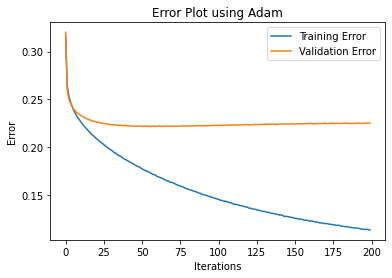

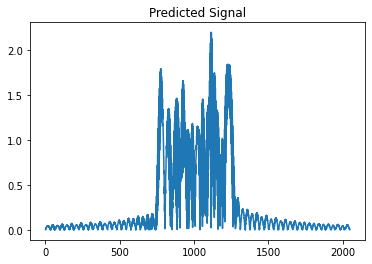

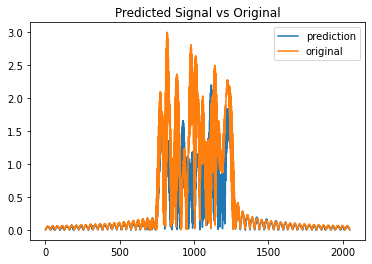

In [42]:
index_pred= 98
y_pred = evals(rect_mlp, X_test, y_test, index_pred, opti, train_err_rect, val_err_rect)

In [43]:
evaluate_ber(y_pred, y_test, index_pred, nsymbols=16)

b : [0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1]
bhat  : [0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1]
ber :  0.015625


### Comments :

* Altough the validation loss is stuck while the training loss still decreases, we are able to get a **BER of 1.56e-2 $\approx 10^{-2}$ !**.

## A shallow network

### Adadelta

In [41]:
optimizer = Adadelta()
opti = 'Adadelta'
n_features = 2048
n_output = 2048
rect_mlp_big = NeuralNetwork(optimizer=optimizer,
                        loss=SquareLoss,
                        validation_data=(X_test, y_test))

In [42]:
rect_mlp_big.add(Dense(32, input_shape=(n_features,)))
rect_mlp_big.add(Activation('selu'))

rect_mlp_big.add(Dense(n_output))
rect_mlp_big.add(Activation('selu'))

print ()
rect_mlp_big.summary(name="MLP-rect-32*2048")


+------------------+
| MLP-rect-32*2048 |
+------------------+
Input Shape: (2048,)
+-------------------+------------+--------------+
| Layer Type        | Parameters | Output Shape |
+-------------------+------------+--------------+
| Dense             | 65568      | (32,)        |
| Activation (SELU) | 0          | (32,)        |
| Dense             | 67584      | (2048,)      |
| Activation (SELU) | 0          | (2048,)      |
+-------------------+------------+--------------+
Total Parameters: 133152



In [244]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", num_epochs)
train_err_rect_mlp_big2, val_err_rect_mlp_big2 = rect_mlp_big.fit(X_train, y_train, num_epochs, batch_size=batch_size)

[INFO] Batch size :  64
[INFO] Training epochs number :  12


[INFO] Training loss on epoch  1  :  0.29734
[INFO] Validation loss on epoch  1  :  0.28816
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  2  :  0.28760
[INFO] Validation loss on epoch  2  :  0.28602
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  3  :  0.28611
[INFO] Validation loss on epoch  3  :  0.28490
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  4  :  0.28519
[INFO] Validation loss on epoch  4  :  0.28428
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  5  :  0.28455
[INFO] Validation loss on epoch  5  :  0.28383
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  6  :  0.28407
[INFO] Validation loss on epoch  6  :  0.28346
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  7  :  0.28369
[INFO] Validation loss on epoch  7  :  0.28318
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  8  :  0.28337
[INFO] Validation loss on epoch  8  :  0.28287
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  9  :  0.28311
[INFO] Validation loss on epoch  9  :  0.28268
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  10  :  0.28290
[INFO] Validation loss on epoch  10  :  0.28253
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  11  :  0.28270
[INFO] Validation loss on epoch  11  :  0.28245
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  12  :  0.28253
[INFO] Validation loss on epoch  12  :  0.28239
-------------------------------------------------------------------------------


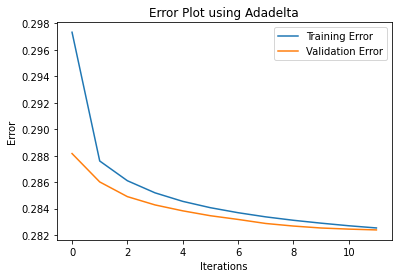

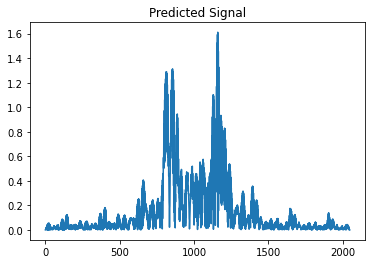

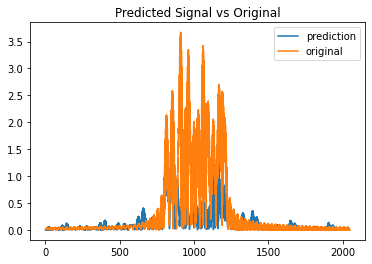

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 142.88it/s]


 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 200.13it/s]


 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)


b :  [1 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 0 0
 1 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 1 0 0]
bhat :  [1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0
 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1]
ber :  0.40625
ser :  42.03097453886764


array([[7.85226158e-05, 7.85226158e-05, 7.70677081e-03, ...,
        2.87838071e-03, 7.85226158e-05, 7.85226158e-05]])

In [245]:
index_pred= 98
evals(rect_mlp_big, X_test, y_test, index_pred, opti, train_err_rect_mlp_big2, val_err_rect_mlp_big2)

### Comments :

* The training and validation loss curve looks good. With this simple network, we are able to get a **BER of $\approx 0.4$ !**.

## MSE Loss

### Adam

In [15]:
optimizer = Adam()
opti = 'Adam'
n_features = 2048
n_output = 2048
rect_mlp_deeper_sm = NeuralNetwork(optimizer=optimizer,
                        loss=MSE,
                        validation_data=(X_test, y_test))

### With Phase Activation

In [16]:
rect_mlp_deeper_sm.add(Dense(256, input_shape=(n_features,)))
rect_mlp_deeper_sm.add(Activation('phase_activation'))

rect_mlp_deeper_sm.add(Dense(n_output))
rect_mlp_deeper_sm.add(Activation('selu'))

print ()
rect_mlp_deeper_sm.summary(name="MLP-rect-2*2048")


+-----------------+
| MLP-rect-2*2048 |
+-----------------+
Input Shape: (2048,)
+------------------------------+------------+--------------+
| Layer Type                   | Parameters | Output Shape |
+------------------------------+------------+--------------+
| Dense                        | 524544     | (256,)       |
| Activation (PhaseActivation) | 0          | (256,)       |
| Dense                        | 526336     | (2048,)      |
| Activation (SELU)            | 0          | (2048,)      |
+------------------------------+------------+--------------+
Total Parameters: 1050880



In [190]:
num_epochs = 20
batch_size = 256

In [191]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", num_epochs)
train_err_rect_deeper_sm, val_err_rect_deeper_sm = rect_mlp_deeper_sm.fit(X_train, y_train, n_epochs=num_epochs, batch_size=batch_size)

[INFO] Batch size :  256
[INFO] Training epochs number :  20


[INFO] Training loss on epoch  1  :  0.00247
[INFO] Validation loss on epoch  1  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  2  :  0.00225
[INFO] Validation loss on epoch  2  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  3  :  0.00221
[INFO] Validation loss on epoch  3  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  4  :  0.00219
[INFO] Validation loss on epoch  4  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  5  :  0.00218
[INFO] Validation loss on epoch  5  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  6  :  0.00217
[INFO] Validation loss on epoch  6  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  7  :  0.00217
[INFO] Validation loss on epoch  7  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  8  :  0.00216
[INFO] Validation loss on epoch  8  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  9  :  0.00216
[INFO] Validation loss on epoch  9  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  10  :  0.00216
[INFO] Validation loss on epoch  10  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  11  :  0.00216
[INFO] Validation loss on epoch  11  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  12  :  0.00216
[INFO] Validation loss on epoch  12  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  13  :  0.00216
[INFO] Validation loss on epoch  13  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  14  :  0.00216
[INFO] Validation loss on epoch  14  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  15  :  0.00216
[INFO] Validation loss on epoch  15  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  16  :  0.00216
[INFO] Validation loss on epoch  16  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  17  :  0.00216
[INFO] Validation loss on epoch  17  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  18  :  0.00216
[INFO] Validation loss on epoch  18  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  19  :  0.00215
[INFO] Validation loss on epoch  19  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  20  :  0.00215
[INFO] Validation loss on epoch  20  :  0.00003
-------------------------------------------------------------------------------


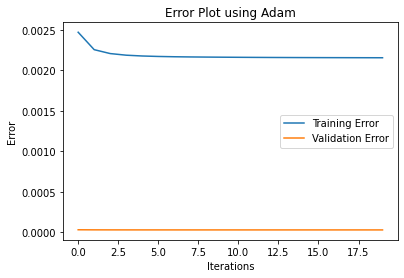

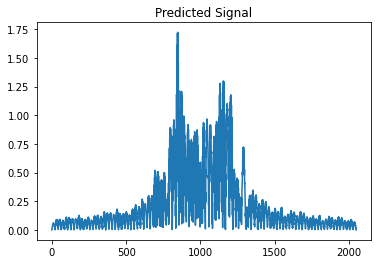

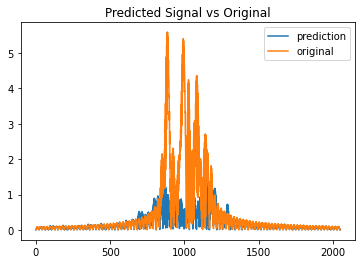

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 120.57it/s]


 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 110.99it/s]


 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)


b :  [1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1
 0 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0]
bhat :  [1 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0
 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1]
ber :  0.5
ser :  61.13384352405663


array([[ 5.43987948e-05,  1.85050105e-10,  1.64494741e-02, ...,
        -2.06395327e-02,  1.09985188e-07,  2.34888764e-06]])

In [239]:
index_pred= 0
evals(rect_mlp_deeper_sm, X_test, y_test, index_pred, opti, train_err_rect_deeper_sm, val_err_rect_deeper_sm)

### With SELU Activation

In [17]:
optimizer = Adam()
opti = 'Adam'
n_features = 2048
n_output = 2048
rect_mlp_big = NeuralNetwork(optimizer=optimizer,
                        loss=MSE,
                        validation_data=(X_test, y_test))

rect_mlp_big.add(Dense(256, input_shape=(n_features,)))
rect_mlp_big.add(Activation('selu'))

rect_mlp_big.add(Dense(n_output))
rect_mlp_big.add(Activation('selu'))

print ()
rect_mlp_big.summary(name="MLP-rect-2*2048")


+-----------------+
| MLP-rect-2*2048 |
+-----------------+
Input Shape: (2048,)
+-------------------+------------+--------------+
| Layer Type        | Parameters | Output Shape |
+-------------------+------------+--------------+
| Dense             | 524544     | (256,)       |
| Activation (SELU) | 0          | (256,)       |
| Dense             | 526336     | (2048,)      |
| Activation (SELU) | 0          | (2048,)      |
+-------------------+------------+--------------+
Total Parameters: 1050880



In [221]:
print("[INFO] Training epochs number : ", num_epochs)
train_err_rect_mlp_big, val_err_rect_mlp_big = rect_mlp_big.fit(X_train, y_train, num_epochs, batch_size=batch_size)

[INFO] Batch size :  128
[INFO] Training epochs number :  20


[INFO] Training loss on epoch  1  :  0.00464
[INFO] Validation loss on epoch  1  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  2  :  0.00445
[INFO] Validation loss on epoch  2  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  3  :  0.00442
[INFO] Validation loss on epoch  3  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  4  :  0.00441
[INFO] Validation loss on epoch  4  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  5  :  0.00440
[INFO] Validation loss on epoch  5  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  6  :  0.00439
[INFO] Validation loss on epoch  6  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  7  :  0.00438
[INFO] Validation loss on epoch  7  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  8  :  0.00438
[INFO] Validation loss on epoch  8  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  9  :  0.00437
[INFO] Validation loss on epoch  9  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  10  :  0.00437
[INFO] Validation loss on epoch  10  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  11  :  0.00436
[INFO] Validation loss on epoch  11  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  12  :  0.00436
[INFO] Validation loss on epoch  12  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  13  :  0.00436
[INFO] Validation loss on epoch  13  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  14  :  0.00436
[INFO] Validation loss on epoch  14  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  15  :  0.00435
[INFO] Validation loss on epoch  15  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  16  :  0.00435
[INFO] Validation loss on epoch  16  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  17  :  0.00435
[INFO] Validation loss on epoch  17  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  18  :  0.00435
[INFO] Validation loss on epoch  18  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  19  :  0.00435
[INFO] Validation loss on epoch  19  :  0.00003
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  20  :  0.00435
[INFO] Validation loss on epoch  20  :  0.00003
-------------------------------------------------------------------------------


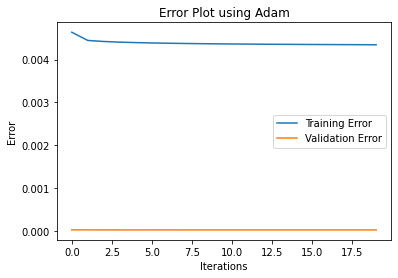

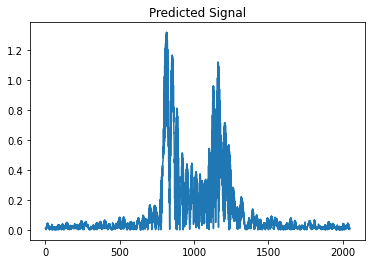

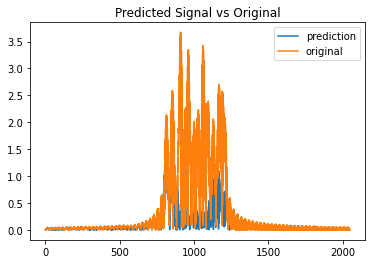

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 114.63it/s]


 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.24it/s]


 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)


b :  [1 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 0 0
 1 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 1 0 0]
bhat :  [1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1]
ber :  0.40625
ser :  42.03097453886764


array([[-0.01130037,  0.01521579, -0.01489532, ..., -0.00192999,
        -0.01130032, -0.01130033]])

In [240]:
index_pred= 98
evals(rect_mlp_big, X_test, y_test, index_pred, opti, train_err_rect_mlp_big, val_err_rect_mlp_big)

#### Comments :

* In this experience, we evaluated the effect of changing the activation function. We can see that the phase activation helps the model achieve a low MSE on the training, but selu give the same test MSE. 
* Overall, we have the same performance as before.

### Remarks and choosed loss :

* This model is able to reach a very low **MSE on testing 3e-5** although it doesn't evolve over time, which is due to the fact that the mean value of y_test[index] is 0.04, centered values are <=4, furthermore the lentgh of y_test[index] is 2048, therefore, the loss is too small and the model doesn't learn so well, this is shown by the **BER is 0.5 !**. The SER is $\approx $ 57.
* The MSE loss is maybe not adapted so we will use only the **squareloss** which gives more stable networks.

$$L(y ,\widehat{y}) = \frac{1}{2}(y - \widehat{y})^{2}$$
$$\frac{\partial L(y ,\widehat{y})}{\partial y} = (y - \widehat{y})$$

# Autoencoder like

In [43]:
optimizer = Adam()
opti = 'Adam'
n_features = 2048
n_output = 2048
autoenc = NeuralNetwork(optimizer=optimizer,
                        loss=SquareLoss,
                        validation_data=(X_test, y_test))

In [44]:
autoenc.add(Dense(64, input_shape=(n_features,)))
autoenc.add(Activation('selu'))
autoenc.add(Dropout(0.25))
autoenc.add(BatchNormalization())

autoenc.add(Dense(32))
autoenc.add(Activation('selu'))
autoenc.add(Dropout(0.25))
autoenc.add(BatchNormalization())

autoenc.add(Dense(16))
autoenc.add(Activation('selu'))
autoenc.add(Dropout(0.25))
autoenc.add(BatchNormalization())

autoenc.add(Dense(32))
autoenc.add(Activation('selu'))
autoenc.add(Dropout(0.25))
autoenc.add(BatchNormalization())

autoenc.add(Dense(64))
autoenc.add(Activation('selu'))
autoenc.add(Dropout(0.25))
autoenc.add(BatchNormalization())

autoenc.add(Dense(n_output))
autoenc.add(Activation('selu'))

print ()
autoenc.summary(name="Autoencoder like")


+------------------+
| Autoencoder like |
+------------------+
Input Shape: (2048,)
+--------------------+------------+--------------+
| Layer Type         | Parameters | Output Shape |
+--------------------+------------+--------------+
| Dense              | 131136     | (64,)        |
| Activation (SELU)  | 0          | (64,)        |
| Dropout            | 0          | (64,)        |
| BatchNormalization | 128        | (64,)        |
| Dense              | 2080       | (32,)        |
| Activation (SELU)  | 0          | (32,)        |
| Dropout            | 0          | (32,)        |
| BatchNormalization | 64         | (32,)        |
| Dense              | 528        | (16,)        |
| Activation (SELU)  | 0          | (16,)        |
| Dropout            | 0          | (16,)        |
| BatchNormalization | 32         | (16,)        |
| Dense              | 544        | (32,)        |
| Activation (SELU)  | 0          | (32,)        |
| Dropout            | 0          | (32,)       

In [234]:
batch_size = 256
num_epochs = 40

In [9]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", num_epochs)
train_err, val_err = clf.fit(X_train, y_train, num_epochs, batch_size=batch_size)

[INFO] Batch size :  256
[INFO] Training epochs number :  40


[INFO] Training loss on epoch  1  :  0.35274
[INFO] Validation loss on epoch  1  :  0.30666
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  2  :  0.30192
[INFO] Validation loss on epoch  2  :  0.28373
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  3  :  0.29279
[INFO] Validation loss on epoch  3  :  0.27970
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  4  :  0.28783
[INFO] Validation loss on epoch  4  :  0.27543
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  5  :  0.28352
[INFO] Validation loss on epoch  5  :  0.27256
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  6  :  0.28176
[INFO] Validation loss on epoch  6  :  0.27180
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  7  :  0.28081
[INFO] Validation loss on epoch  7  :  0.27132
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  8  :  0.28021
[INFO] Validation loss on epoch  8  :  0.27112
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  9  :  0.27949
[INFO] Validation loss on epoch  9  :  0.27072
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  10  :  0.27915
[INFO] Validation loss on epoch  10  :  0.27046
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  11  :  0.27874
[INFO] Validation loss on epoch  11  :  0.27015
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  12  :  0.27840
[INFO] Validation loss on epoch  12  :  0.26991
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  13  :  0.27820
[INFO] Validation loss on epoch  13  :  0.26957
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  14  :  0.27776
[INFO] Validation loss on epoch  14  :  0.26937
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  15  :  0.27752
[INFO] Validation loss on epoch  15  :  0.26906
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  16  :  0.27721
[INFO] Validation loss on epoch  16  :  0.26890
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  17  :  0.27709
[INFO] Validation loss on epoch  17  :  0.26876
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  18  :  0.27687
[INFO] Validation loss on epoch  18  :  0.26857
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  19  :  0.27673
[INFO] Validation loss on epoch  19  :  0.26838
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  20  :  0.27657
[INFO] Validation loss on epoch  20  :  0.26829
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  21  :  0.27649
[INFO] Validation loss on epoch  21  :  0.26828
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  22  :  0.27627
[INFO] Validation loss on epoch  22  :  0.26814
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  23  :  0.27622
[INFO] Validation loss on epoch  23  :  0.26798
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  24  :  0.27611
[INFO] Validation loss on epoch  24  :  0.26788
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  25  :  0.27607
[INFO] Validation loss on epoch  25  :  0.26785
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  26  :  0.27590
[INFO] Validation loss on epoch  26  :  0.26770
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  27  :  0.27588
[INFO] Validation loss on epoch  27  :  0.26765
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  28  :  0.27565
[INFO] Validation loss on epoch  28  :  0.26753
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  29  :  0.27560
[INFO] Validation loss on epoch  29  :  0.26722
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  30  :  0.27512
[INFO] Validation loss on epoch  30  :  0.26614
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  31  :  0.27435
[INFO] Validation loss on epoch  31  :  0.26483
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  32  :  0.27398
[INFO] Validation loss on epoch  32  :  0.26409
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  33  :  0.27360
[INFO] Validation loss on epoch  33  :  0.26346
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  34  :  0.27314
[INFO] Validation loss on epoch  34  :  0.26314
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  35  :  0.27303
[INFO] Validation loss on epoch  35  :  0.26273
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  36  :  0.27277
[INFO] Validation loss on epoch  36  :  0.26234
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  37  :  0.27273
[INFO] Validation loss on epoch  37  :  0.26229
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  38  :  0.27242
[INFO] Validation loss on epoch  38  :  0.26187
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  39  :  0.27215
[INFO] Validation loss on epoch  39  :  0.26152
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  40  :  0.27198
[INFO] Validation loss on epoch  40  :  0.26123
-------------------------------------------------------------------------------


### Evaluation & Testing

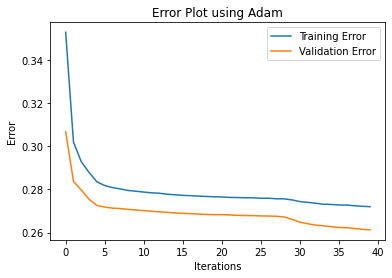

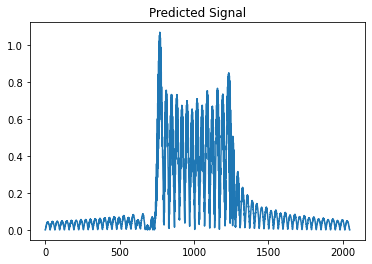

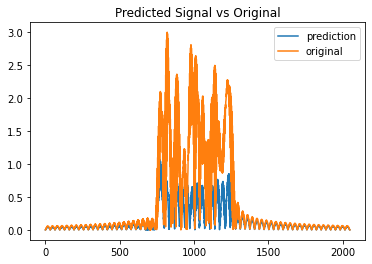

In [16]:
index_pred= 98
evals(clf, X_test, y_test, index_pred, opti, train_err, val_err)

### More parametrized Autoencoder

In [146]:
optimizer = Adam()
opti = 'Adam'
n_features = 2048
n_output = 2048
autoenc_big = NeuralNetwork(optimizer=optimizer,
                        loss=MSE,
                        validation_data=(X_test, y_test))

In [147]:
autoenc_big.add(Dense(512, input_shape=(n_features,)))
autoenc_big.add(Activation('elu'))
autoenc_big.add(Dropout(0.25))
autoenc_big.add(BatchNormalization())

autoenc_big.add(Dense(256))
autoenc_big.add(Activation('elu'))
autoenc_big.add(Dropout(0.25))
autoenc_big.add(BatchNormalization())

autoenc_big.add(Dense(32))
autoenc_big.add(Activation('elu'))
autoenc_big.add(Dropout(0.25))
autoenc_big.add(BatchNormalization())

autoenc_big.add(Dense(256))
autoenc_big.add(Activation('elu'))
autoenc_big.add(Dropout(0.25))
autoenc_big.add(BatchNormalization())

autoenc_big.add(Dense(512))
autoenc_big.add(Activation('elu'))
autoenc_big.add(Dropout(0.25))
autoenc_big.add(BatchNormalization())

autoenc_big.add(Dense(n_output))
autoenc_big.add(Activation('elu'))

print ()
autoenc_big.summary(name="Autoencoder like")


+------------------+
| Autoencoder like |
+------------------+
Input Shape: (2048,)
+--------------------+------------+--------------+
| Layer Type         | Parameters | Output Shape |
+--------------------+------------+--------------+
| Dense              | 1049088    | (512,)       |
| Activation (ELU)   | 0          | (512,)       |
| Dropout            | 0          | (512,)       |
| BatchNormalization | 1024       | (512,)       |
| Dense              | 131328     | (256,)       |
| Activation (ELU)   | 0          | (256,)       |
| Dropout            | 0          | (256,)       |
| BatchNormalization | 512        | (256,)       |
| Dense              | 8224       | (32,)        |
| Activation (ELU)   | 0          | (32,)        |
| Dropout            | 0          | (32,)        |
| BatchNormalization | 64         | (32,)        |
| Dense              | 8448       | (256,)       |
| Activation (ELU)   | 0          | (256,)       |
| Dropout            | 0          | (256,)      

In [148]:
num_epochs = 40
batch_size = 256

### Evaluation & Testing

In [154]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", num_epochs)
train_err, val_err = clf.fit(X_train, y_train, num_epochs, batch_size=batch_size)

[INFO] Batch size :  256
[INFO] Training epochs number :  40


[INFO] Training loss on epoch  1  :  0.38664
[INFO] Validation loss on epoch  1  :  0.45719
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  2  :  0.32438
[INFO] Validation loss on epoch  2  :  0.30900
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  3  :  0.30833
[INFO] Validation loss on epoch  3  :  0.28927
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  4  :  0.30047
[INFO] Validation loss on epoch  4  :  0.28243
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  5  :  0.29477
[INFO] Validation loss on epoch  5  :  0.27905
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  6  :  0.29091
[INFO] Validation loss on epoch  6  :  0.27661
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  7  :  0.28747
[INFO] Validation loss on epoch  7  :  0.27439
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  8  :  0.28447
[INFO] Validation loss on epoch  8  :  0.27287
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  9  :  0.28145
[INFO] Validation loss on epoch  9  :  0.27200
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  10  :  0.27918
[INFO] Validation loss on epoch  10  :  0.27177
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  11  :  0.27649
[INFO] Validation loss on epoch  11  :  0.27094
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  12  :  0.27437
[INFO] Validation loss on epoch  12  :  0.27004
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  13  :  0.27226
[INFO] Validation loss on epoch  13  :  0.26977
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  14  :  0.26992
[INFO] Validation loss on epoch  14  :  0.26901
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  15  :  0.26790
[INFO] Validation loss on epoch  15  :  0.26887
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  16  :  0.26578
[INFO] Validation loss on epoch  16  :  0.26908
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  17  :  0.26420
[INFO] Validation loss on epoch  17  :  0.26886
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  18  :  0.26176
[INFO] Validation loss on epoch  18  :  0.26918
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  19  :  0.26025
[INFO] Validation loss on epoch  19  :  0.26916
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  20  :  0.25811
[INFO] Validation loss on epoch  20  :  0.26949
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  21  :  0.25675
[INFO] Validation loss on epoch  21  :  0.26865
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  22  :  0.25503
[INFO] Validation loss on epoch  22  :  0.26917
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  23  :  0.25308
[INFO] Validation loss on epoch  23  :  0.26918
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  24  :  0.25161
[INFO] Validation loss on epoch  24  :  0.26879
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  25  :  0.24990
[INFO] Validation loss on epoch  25  :  0.26896
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  26  :  0.24797
[INFO] Validation loss on epoch  26  :  0.26944
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  27  :  0.24733
[INFO] Validation loss on epoch  27  :  0.26930
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  28  :  0.24510
[INFO] Validation loss on epoch  28  :  0.26920
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  29  :  0.24403
[INFO] Validation loss on epoch  29  :  0.26853
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  30  :  0.24323
[INFO] Validation loss on epoch  30  :  0.26860
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  31  :  0.24160
[INFO] Validation loss on epoch  31  :  0.26830
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  32  :  0.24028
[INFO] Validation loss on epoch  32  :  0.26882
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  33  :  0.23879
[INFO] Validation loss on epoch  33  :  0.26758
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  34  :  0.23788
[INFO] Validation loss on epoch  34  :  0.26820
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  35  :  0.23653
[INFO] Validation loss on epoch  35  :  0.26759
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  36  :  0.23546
[INFO] Validation loss on epoch  36  :  0.26797
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  37  :  0.23400
[INFO] Validation loss on epoch  37  :  0.26803
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  38  :  0.23265
[INFO] Validation loss on epoch  38  :  0.26851
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  39  :  0.23114
[INFO] Validation loss on epoch  39  :  0.26818
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  40  :  0.23040
[INFO] Validation loss on epoch  40  :  0.26799
-------------------------------------------------------------------------------


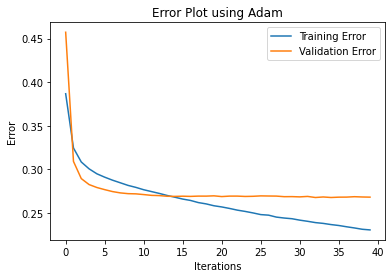

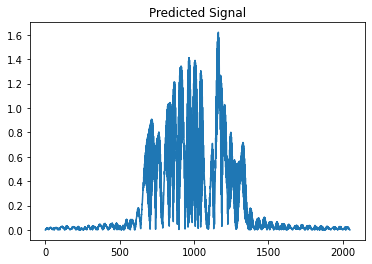

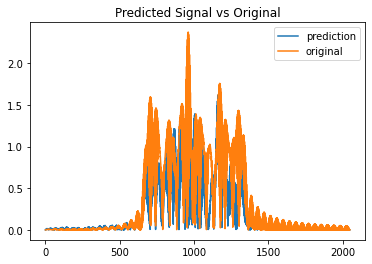

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 142.79it/s]


 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 143.60it/s]


 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)
(1, 1024)


b :  [0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1]
bhat :  [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
ber :  0.1875


array([[-1.86295461e-11, -4.11847180e-14,  3.52947303e-03, ...,
         4.98945599e-03, -2.39833057e-10,  1.18667531e-09]])

In [155]:
index_pred= 98
evals(clf, X_test, y_test, index_pred, opti, train_err, val_err)

### Comments :

* Altough the validation loss is stuck while the training loss still decreases, we are able to get a **BER of $\approx 0.18$ !**.

### Over-parametrized Autoencoder

In [48]:
optimizer = Adagrad()
opti = 'Adagrad'
n_features = 2048
n_output = 2048
autoenc_big = NeuralNetwork(optimizer=optimizer,
                        loss=SquareLoss,
                        validation_data=(X_test, y_test))

In [49]:
#all active were selu
autoenc_big.add(Dense(2048, input_shape=(n_features,)))
autoenc_big.add(Activation('elu'))
autoenc_big.add(Dropout(0.25))
autoenc_big.add(BatchNormalization())

autoenc_big.add(Dense(256))
autoenc_big.add(Activation('elu'))
autoenc_big.add(Dropout(0.25))
autoenc_big.add(BatchNormalization())

autoenc_big.add(Dense(128))
autoenc_big.add(Activation('elu'))
autoenc_big.add(Dropout(0.25))
autoenc_big.add(BatchNormalization())

autoenc_big.add(Dense(256))
autoenc_big.add(Activation('elu'))
autoenc_big.add(Dropout(0.25))
autoenc_big.add(BatchNormalization())

autoenc_big.add(Dense(n_output))
autoenc_big.add(Activation('elu'))

print ()
autoenc_big.summary(name="Over-parametrized Autoencoder")


+-------------------------------+
| Over-parametrized Autoencoder |
+-------------------------------+
Input Shape: (2048,)
+--------------------+------------+--------------+
| Layer Type         | Parameters | Output Shape |
+--------------------+------------+--------------+
| Dense              | 4196352    | (2048,)      |
| Activation (ELU)   | 0          | (2048,)      |
| Dropout            | 0          | (2048,)      |
| BatchNormalization | 4096       | (2048,)      |
| Dense              | 524544     | (256,)       |
| Activation (ELU)   | 0          | (256,)       |
| Dropout            | 0          | (256,)       |
| BatchNormalization | 512        | (256,)       |
| Dense              | 32896      | (128,)       |
| Activation (ELU)   | 0          | (128,)       |
| Dropout            | 0          | (128,)       |
| BatchNormalization | 256        | (128,)       |
| Dense              | 33024      | (256,)       |
| Activation (ELU)   | 0          | (256,)       |
| Dropout

In [263]:
num_epochs = 40
batch_size = 128

In [264]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", num_epochs)
train_err_autoenc_big, val_err_autoenc_big = autoenc_big.fit(X_train, y_train, num_epochs, batch_size=batch_size)

[INFO] Batch size :  128
[INFO] Training epochs number :  40


[INFO] Training loss on epoch  1  :  0.32515
[INFO] Validation loss on epoch  1  :  0.31362
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  2  :  0.31591
[INFO] Validation loss on epoch  2  :  0.30891
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  3  :  0.31237
[INFO] Validation loss on epoch  3  :  0.30549
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  4  :  0.30989
[INFO] Validation loss on epoch  4  :  0.30327
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  5  :  0.30807
[INFO] Validation loss on epoch  5  :  0.30168
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  6  :  0.30667
[INFO] Validation loss on epoch  6  :  0.30036
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  7  :  0.30553
[INFO] Validation loss on epoch  7  :  0.29935
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  8  :  0.30473
[INFO] Validation loss on epoch  8  :  0.29853
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  9  :  0.30381
[INFO] Validation loss on epoch  9  :  0.29779
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  10  :  0.30305
[INFO] Validation loss on epoch  10  :  0.29708
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  11  :  0.30244
[INFO] Validation loss on epoch  11  :  0.29653
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  12  :  0.30180
[INFO] Validation loss on epoch  12  :  0.29601
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  13  :  0.30129
[INFO] Validation loss on epoch  13  :  0.29543
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  14  :  0.30074
[INFO] Validation loss on epoch  14  :  0.29496
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  15  :  0.30021
[INFO] Validation loss on epoch  15  :  0.29456
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  16  :  0.29967
[INFO] Validation loss on epoch  16  :  0.29412
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  17  :  0.29931
[INFO] Validation loss on epoch  17  :  0.29374
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  18  :  0.29895
[INFO] Validation loss on epoch  18  :  0.29339
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  19  :  0.29848
[INFO] Validation loss on epoch  19  :  0.29297
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  20  :  0.29808
[INFO] Validation loss on epoch  20  :  0.29262
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  21  :  0.29772
[INFO] Validation loss on epoch  21  :  0.29237
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  22  :  0.29747
[INFO] Validation loss on epoch  22  :  0.29206
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  23  :  0.29705
[INFO] Validation loss on epoch  23  :  0.29179
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  24  :  0.29671
[INFO] Validation loss on epoch  24  :  0.29148
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  25  :  0.29638
[INFO] Validation loss on epoch  25  :  0.29121
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  26  :  0.29614
[INFO] Validation loss on epoch  26  :  0.29102
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  27  :  0.29583
[INFO] Validation loss on epoch  27  :  0.29077
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  28  :  0.29550
[INFO] Validation loss on epoch  28  :  0.29055
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  29  :  0.29532
[INFO] Validation loss on epoch  29  :  0.29039
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  30  :  0.29511
[INFO] Validation loss on epoch  30  :  0.29007
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  31  :  0.29472
[INFO] Validation loss on epoch  31  :  0.28997
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  32  :  0.29452
[INFO] Validation loss on epoch  32  :  0.28971
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  33  :  0.29424
[INFO] Validation loss on epoch  33  :  0.28958
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  34  :  0.29398
[INFO] Validation loss on epoch  34  :  0.28935
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  35  :  0.29375
[INFO] Validation loss on epoch  35  :  0.28913
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  36  :  0.29349
[INFO] Validation loss on epoch  36  :  0.28899
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  37  :  0.29336
[INFO] Validation loss on epoch  37  :  0.28885
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  38  :  0.29315
[INFO] Validation loss on epoch  38  :  0.28865
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  39  :  0.29290
[INFO] Validation loss on epoch  39  :  0.28855
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  40  :  0.29264
[INFO] Validation loss on epoch  40  :  0.28841
-------------------------------------------------------------------------------


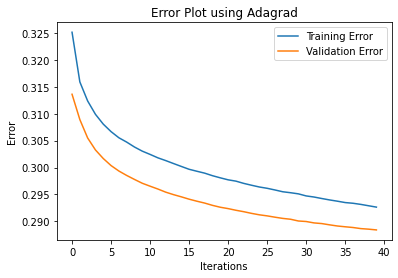

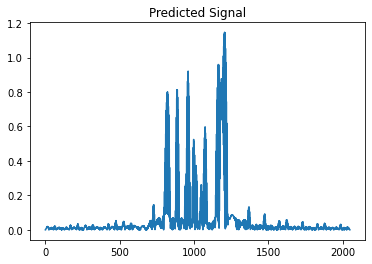

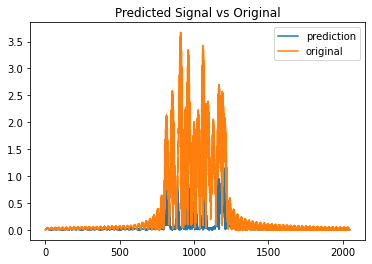

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s]


 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 125.08it/s]


 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)


b :  [1 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 0 0
 1 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 1 0 0]
bhat :  [1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0
 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1]
ber :  0.34375
ser :  42.03097453886764


array([[-0.00022418, -0.00026453, -0.00429047, ...,  0.00468007,
        -0.00026697, -0.00028179]])

In [265]:
index_pred= 98
evals(autoenc_big, X_test, y_test, index_pred, opti, train_err_autoenc_big, val_err_autoenc_big)

### Comments :

* The over-parametrization didn't help in improving the BER. The training and validation loss curve looks good, they are continuously decreasing which means that the model is converging, we are able to get a **BER of  $\approx 0.34$ !**.

# Bigger dataset

In [50]:
optimizer = Adam()
opti = 'Adam'
n_features = 2048
n_output = 2048
mlp_autoenc_like = NeuralNetwork(optimizer=optimizer,
                        loss=SquareLoss,
                        validation_data=(X_test, y_test))

In [51]:
mlp_autoenc_like.add(Dense(512, input_shape=(n_features,)))
mlp_autoenc_like.add(Activation('selu'))
mlp_autoenc_like.add(Dropout(0.25))
mlp_autoenc_like.add(BatchNormalization())

mlp_autoenc_like.add(Dense(256))
mlp_autoenc_like.add(Activation('selu'))
mlp_autoenc_like.add(Dropout(0.25))
mlp_autoenc_like.add(BatchNormalization())

mlp_autoenc_like.add(Dense(64))
mlp_autoenc_like.add(Activation('selu'))
mlp_autoenc_like.add(Dropout(0.25))
mlp_autoenc_like.add(BatchNormalization())

mlp_autoenc_like.add(Dense(256))
mlp_autoenc_like.add(Activation('selu'))
mlp_autoenc_like.add(Dropout(0.25))
mlp_autoenc_like.add(BatchNormalization())

mlp_autoenc_like.add(Dense(512))
mlp_autoenc_like.add(Activation('selu'))
mlp_autoenc_like.add(Dropout(0.25))
mlp_autoenc_like.add(BatchNormalization())

mlp_autoenc_like.add(Dense(n_output))
mlp_autoenc_like.add(Activation('selu'))

print ()
mlp_autoenc_like.summary(name="Autoencoder-like")


+------------------+
| Autoencoder-like |
+------------------+
Input Shape: (2048,)
+--------------------+------------+--------------+
| Layer Type         | Parameters | Output Shape |
+--------------------+------------+--------------+
| Dense              | 1049088    | (512,)       |
| Activation (SELU)  | 0          | (512,)       |
| Dropout            | 0          | (512,)       |
| BatchNormalization | 1024       | (512,)       |
| Dense              | 131328     | (256,)       |
| Activation (SELU)  | 0          | (256,)       |
| Dropout            | 0          | (256,)       |
| BatchNormalization | 512        | (256,)       |
| Dense              | 16448      | (64,)        |
| Activation (SELU)  | 0          | (64,)        |
| Dropout            | 0          | (64,)        |
| BatchNormalization | 128        | (64,)        |
| Dense              | 16640      | (256,)       |
| Activation (SELU)  | 0          | (256,)       |
| Dropout            | 0          | (256,)      

In [81]:
num_epochs = 40
batch_size = 128

In [82]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", num_epochs)
train_err_autoenc_lik, val_err_autoenc_lik = mlp_autoenc_like.fit(X_train, y_train, num_epochs, batch_size=batch_size)

[INFO] Batch size :  128
[INFO] Training epochs number :  40


[INFO] Training loss on epoch  1  :  0.27638
[INFO] Validation loss on epoch  1  :  0.24950
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  2  :  0.25448
[INFO] Validation loss on epoch  2  :  0.24095
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  3  :  0.24863
[INFO] Validation loss on epoch  3  :  0.23584
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  4  :  0.24511
[INFO] Validation loss on epoch  4  :  0.23240
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  5  :  0.24256
[INFO] Validation loss on epoch  5  :  0.22953
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  6  :  0.24046
[INFO] Validation loss on epoch  6  :  0.22715
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  7  :  0.23865
[INFO] Validation loss on epoch  7  :  0.22509
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  8  :  0.23723
[INFO] Validation loss on epoch  8  :  0.22348
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  9  :  0.23595
[INFO] Validation loss on epoch  9  :  0.22183
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  10  :  0.23471
[INFO] Validation loss on epoch  10  :  0.22043
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  11  :  0.23357
[INFO] Validation loss on epoch  11  :  0.21921
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  12  :  0.23267
[INFO] Validation loss on epoch  12  :  0.21814
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  13  :  0.23162
[INFO] Validation loss on epoch  13  :  0.21705
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  14  :  0.23081
[INFO] Validation loss on epoch  14  :  0.21616
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  15  :  0.23009
[INFO] Validation loss on epoch  15  :  0.21545
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  16  :  0.22922
[INFO] Validation loss on epoch  16  :  0.21434
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  17  :  0.22878
[INFO] Validation loss on epoch  17  :  0.21357
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  18  :  0.22805
[INFO] Validation loss on epoch  18  :  0.21315
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  19  :  0.22749
[INFO] Validation loss on epoch  19  :  0.21229
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  20  :  0.22683
[INFO] Validation loss on epoch  20  :  0.21158
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  21  :  0.22620
[INFO] Validation loss on epoch  21  :  0.21087
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  22  :  0.22559
[INFO] Validation loss on epoch  22  :  0.21026
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  23  :  0.22510
[INFO] Validation loss on epoch  23  :  0.20983
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  24  :  0.22457
[INFO] Validation loss on epoch  24  :  0.20888
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  25  :  0.22405
[INFO] Validation loss on epoch  25  :  0.20832
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  26  :  0.22359
[INFO] Validation loss on epoch  26  :  0.20776
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  27  :  0.22322
[INFO] Validation loss on epoch  27  :  0.20713
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  28  :  0.22285
[INFO] Validation loss on epoch  28  :  0.20666
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  29  :  0.22225
[INFO] Validation loss on epoch  29  :  0.20634
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  30  :  0.22179
[INFO] Validation loss on epoch  30  :  0.20585
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  31  :  0.22145
[INFO] Validation loss on epoch  31  :  0.20519
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  32  :  0.22110
[INFO] Validation loss on epoch  32  :  0.20443
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  33  :  0.22060
[INFO] Validation loss on epoch  33  :  0.20400
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  34  :  0.22025
[INFO] Validation loss on epoch  34  :  0.20366
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  35  :  0.21992
[INFO] Validation loss on epoch  35  :  0.20311
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  36  :  0.21941
[INFO] Validation loss on epoch  36  :  0.20259
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  37  :  0.21912
[INFO] Validation loss on epoch  37  :  0.20218
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  38  :  0.21882
[INFO] Validation loss on epoch  38  :  0.20188
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  39  :  0.21849
[INFO] Validation loss on epoch  39  :  0.20150
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  40  :  0.21824
[INFO] Validation loss on epoch  40  :  0.20117
-------------------------------------------------------------------------------


### Testing

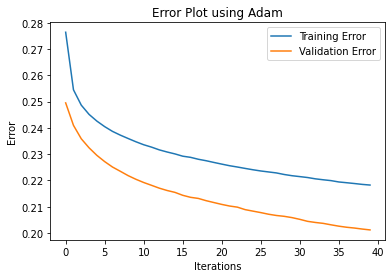

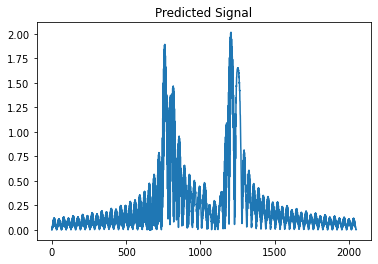

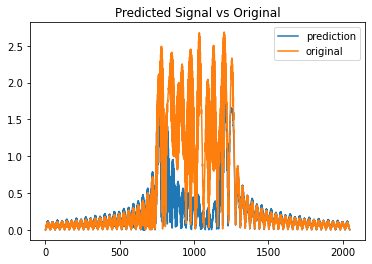

In [84]:
index_pred= 98
y_pred = evals(mlp_autoenc_like, X_test, y_test, index_pred, opti, train_err_autoenc_lik, val_err_autoenc_lik)

In [85]:
evaluate_ber(y_pred, y_test, index_pred, nsymbols=16)

b : [0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1]
bhat  : [0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1]
ber :  0.015625


### Comments :

* The training and validation loss curve looks good. With this network trained on a bigger dataset, we achieve really good results from the plots (jupyter crashed after and couldn't check the BER). The predicted signal and original one are almost the same !

# Convolutional Neural Network - Conv2D

In [216]:
def plot_transformed_to_img(index_plot):

    plt.imshow(X_train[index_plot][0])
    plt.title("Image on channel 1")
    plt.show()

    plt.imshow(X_train[index_plot][1])
    plt.title("Image on channel 2")
    plt.show()

In [27]:
num_epochs = 10
batch_size = 32

In [28]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", num_epochs)
train_err, val_err = clf.fit(X_train, y_train, num_epochs, batch_size=batch_size)

[INFO] Batch size :  32
[INFO] Training epochs number :  10


[INFO] Training loss on epoch  1  :  0.46162
[INFO] Validation loss on epoch  1  :  0.62825
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  2  :  0.38110
[INFO] Validation loss on epoch  2  :  0.36889
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  3  :  0.35000
[INFO] Validation loss on epoch  3  :  0.32711
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  4  :  0.33816
[INFO] Validation loss on epoch  4  :  0.31680
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  5  :  0.33085
[INFO] Validation loss on epoch  5  :  0.31323
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  6  :  0.32529
[INFO] Validation loss on epoch  6  :  0.31138
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  7  :  0.32103
[INFO] Validation loss on epoch  7  :  0.31039
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  8  :  0.31825
[INFO] Validation loss on epoch  8  :  0.30951
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  9  :  0.31598
[INFO] Validation loss on epoch  9  :  0.30862
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  10  :  0.31362
[INFO] Validation loss on epoch  10  :  0.30755
-------------------------------------------------------------------------------


### Evaluation

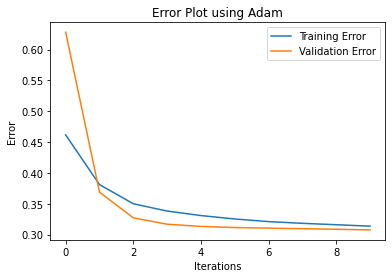

In [31]:
# Training and validation error plot
n = len(train_err)
training, = plt.plot(range(n), train_err, label="Training Error")
validation, = plt.plot(range(n), val_err, label="Validation Error")
plt.legend(handles=[training, validation])
plt.title("Error Plot using "+str(opti))
plt.ylabel('Error')
plt.xlabel('Iterations')
plt.show()

In [32]:
_, loss = clf.test_on_batch(X_test, y_test)
print ("Test loss:", loss)

Test loss: 0


### Testing the Conv2D

In [34]:
x_tester = X_test.reshape(X_test.shape[0], -1, 2,32,32)
x_test_original = X_test.reshape(X_test.shape[0], 2048,1)

In [35]:
index_pred = 54

[[0.04409289 0.00688274 0.04464493 ... 0.06249855 0.03349153 0.05991256]]


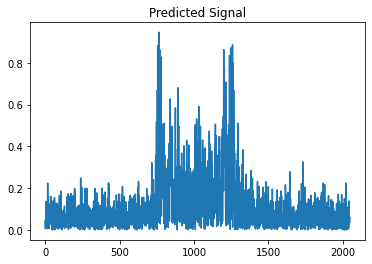

In [36]:
y_pred = clf.predict(x_tester[index_pred])
print(y_pred)
plt.title("Predicted Signal")
plt.plot(np.squeeze(np.abs(y_pred)))
plt.show()

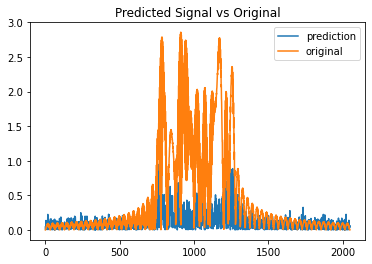

In [37]:
plt.title("Predicted Signal vs Original")
plt.plot(np.squeeze(np.abs(y_pred)), label="prediction")
plt.plot(np.squeeze(np.abs(y_test[index_pred])), label="original")
plt.legend()
plt.show()

## More deep Conv2D

In [213]:
optimizer = Adam()
opti = 'Adam'
n_features = 2048
n_output = 2048
model_deep = NeuralNetwork(optimizer=optimizer,
                        loss=SquareLoss,
                        validation_data=(X_test, y_test))

In [214]:
model_deep.add(Conv2D(n_filters=256, filter_shape=(3,3), stride=1, input_shape=(2,32,32), padding='same'))
model_deep.add(Activation('phase_activation'))
model_deep.add(Dropout(0.25))
model_deep.add(BatchNormalization())

model_deep.add(Conv2D(n_filters=128, filter_shape=(2,2), stride=1, padding='same'))
model_deep.add(Activation('selu'))
model_deep.add(Dropout(0.25))
model_deep.add(BatchNormalization())

model_deep.add(Flatten())

model_deep.add(Dense(32))
model_deep.add(Activation('selu'))
model_deep.add(Dropout(0.3))
model_deep.add(BatchNormalization())

model_deep.add(Dense(8))
model_deep.add(Activation('selu'))
model_deep.add(Dropout(0.2))
model_deep.add(BatchNormalization())

model_deep.add(Dense(32))
model_deep.add(Activation('selu'))
model_deep.add(Dropout(0.3))
model_deep.add(BatchNormalization())

model_deep.add(Dense(n_output))
model_deep.add(Activation('selu'))
print ()
model_deep.summary(name="Conv2D-deep")


+-------------+
| Conv2D-deep |
+-------------+
Input Shape: (2, 32, 32)
+------------------------------+------------+---------------+
| Layer Type                   | Parameters | Output Shape  |
+------------------------------+------------+---------------+
| Conv2D                       | 4864       | (256, 32, 32) |
| Activation (PhaseActivation) | 0          | (256, 32, 32) |
| Dropout                      | 0          | (256, 32, 32) |
| BatchNormalization           | 524288     | (256, 32, 32) |
| Conv2D                       | 131200     | (128, 32, 32) |
| Activation (SELU)            | 0          | (128, 32, 32) |
| Dropout                      | 0          | (128, 32, 32) |
| BatchNormalization           | 262144     | (128, 32, 32) |
| Flatten                      | 0          | (131072,)     |
| Dense                        | 4194336    | (32,)         |
| Activation (SELU)            | 0          | (32,)         |
| Dropout                      | 0          | (32,)       

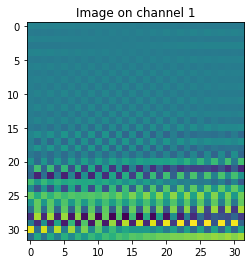

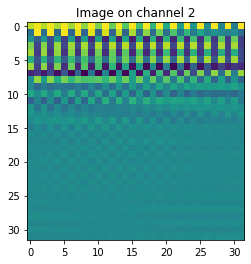

In [217]:
index_plot = 0
plot_transformed_to_img(index_plot)

### Training the model

In [239]:
epochs = 5
batch_size = 1

In [ ]:
withReshape = True
ts = 0.25
X_train_, X_test_, y_train_, y_test_ = prepareTrainAndTestData(df, withReshape, ts)

[INFO] - {prepareTrainAndTestData} converting from pandas to numpy...


In [234]:
x_tr = X_train_[0:100,:,:]
x_te = X_test_[110:115,:,:]
y_tr = y_train_[0:100,:,:]
y_te = y_test_[110:115,:,:]

In [235]:
# Reshape X to (n_samples, channels, height, width) (2*32*32 = 2048)
X_train = x_tr.reshape((x_tr.shape[0],2,32,32))
X_test = x_te.reshape((x_te.shape[0],2,32,32))
y_train = np.squeeze(y_tr)
y_test = np.squeeze(y_te)

In [236]:
X_train.shape

(100, 2, 32, 32)

In [ ]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", epochs)
train_err, val_err = model_deep.fit(X_train, y_train, n_epochs=num_epochs, batch_size=batch_size)

In [ ]:
index_pred= 98
evals(model_deep, X_test, y_test, index_pred, opti, train_err_autoenc_lik, val_err_autoenc_lik)

# II. Bits-To-Bits model

In [142]:
def ber(y_pred, y_tester):
    return np.sum(np.abs(y_pred -y_tester ))/len(y_tester)

def evals_clf(model, X_test, y_test, index_pred, opti, train_err, val_err):
    
    # Training and validation error plot
    n = len(train_err)
    training, = plt.plot(range(n), train_err, label="Training Error")
    validation, = plt.plot(range(n), val_err, label="Validation Error")
    plt.legend(handles=[training, validation])
    plt.title("Error Plot using "+str(opti))
    plt.ylabel('Error')
    plt.xlabel('Iterations')
    plt.show()
    
    y_pred = model.predict(X_test[index_pred])
    y_tester = np.squeeze(y_test[index_pred])
    y_pred = np.squeeze(y_pred)
    y_pred = y_pred.astype('int64')

    print("y_test : ",y_tester)
    print("y_pred : ",y_pred)
    print("BER : ",ber(y_pred, y_tester))
    
    _, accuracy = clf_big.test_on_batch(X_test, y_test)
    print ("Accuracy on all test dataset :", accuracy)

In [6]:
#----------------------------------------------------------------------------#

def prepareDataFrameBits(X, y) :


    data = np.column_stack((X,y))

    df_ = pd.DataFrame(data)
    df_ = shuffle(df_)

    print("{prepareDataFrameBits} df_.shape : ",df_.shape)

    return df_

#----------------------------------------------------------------------------#

def prepareTrainAndTestDataBits(df, withReshape, ts):

  #df = df.set_index('Attribute',inplace=True)
  
    N_samples = df.shape[0]
    N_features = df.shape[1]//2
    N_cols = df.shape[1]

    if type(df) != np.ndarray :
        print("[INFO] - {prepareTrainAndTestDataBits} converting from pandas to numpy...")
        df_np = df.to_numpy()
        X = df_np[:N_samples,0:N_features]
        y = df_np[:N_samples,N_features:N_cols]
    else :
        X = df[:N_samples,0:N_features]
        y = df[:N_samples,N_features:N_cols]

    N_features = len(X[0])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts)

    N_samples_train = len(X_train)
    N_samples_test = len(X_test)

    if withReshape :
        X_train = X_train.reshape(N_samples_train, N_features, 1)
        X_test = X_test.reshape(N_samples_test, N_features, 1)
        y_train = y_train.reshape(N_samples_train, N_features, 1)
        y_test = y_test.reshape(N_samples_test, N_features, 1)

    print(X.shape)
    print(y.shape)
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)

    return X_train, X_test, y_train, y_test
  
#----------------------------------------------------------------------------#

In [17]:
def get_prepared_bits_data(ts= 0.25, withReshape = True):
    
    bits_64 = np.load('../data/bits/20K_bits_64.npz')
    
    X = bits_64['bhat_out'] # distorted source
    y = bits_64['bits_in'] # original source
    
    t1 = time.time()
    df = prepareDataFrameBits(X, y)
    t2 = time.time()
    
    print("[INFO] Total time to prepare the dataframe is : ", t2-t1, " seconds.")

    X_train, X_test, y_train, y_test = prepareTrainAndTestDataBits(df, withReshape, ts)
    
    print("[INFO] Squeezing datas...")
    X_train = np.squeeze(X_train)
    X_test = np.squeeze(X_test)
    y_train = np.squeeze(y_train)
    y_test = np.squeeze(y_test)
    
    return X_train, X_test, y_train, y_test

In [18]:
X_train, X_test, y_train, y_test = get_prepared_bits_data()

{prepareDataFrameBits} df_.shape :  (20000, 128)
[INFO] Total time to prepare the dataframe is :  0.015002250671386719  seconds.
[INFO] - {prepareTrainAndTestDataBits} converting from pandas to numpy...
(20000, 64)
(20000, 64)
(15000, 64, 1)
(15000, 64, 1)
(5000, 64, 1)
(5000, 64, 1)
[INFO] Squeezing datas...


In [34]:
y_train.shape

(15000, 64)

In [129]:
optimizer = Adam()
opti = 'Adam'
n_features = X_train.shape[1]
n_output = y_train.shape[1]
clf_big = NeuralNetwork(optimizer=optimizer,
                        loss=CrossEntropy,
                        validation_data=(X_test, y_test))

In [130]:
clf_big.add(Dense(512, input_shape=(n_features,)))
clf_big.add(Activation('relu'))
clf_big.add(BatchNormalization())

clf_big.add(Dense(256))
clf_big.add(Activation('relu'))
clf_big.add(Dropout(0.25))
clf_big.add(BatchNormalization())

clf_big.add(Dense(128))
clf_big.add(Activation('relu'))
clf_big.add(Dropout(0.25))
clf_big.add(BatchNormalization())

clf_big.add(Dense(256))
clf_big.add(Activation('relu'))
clf_big.add(Dropout(0.25))
clf_big.add(BatchNormalization())

clf_big.add(Dense(n_output))
clf_big.add(Activation('softmax'))

print ()
clf_big.summary(name="Bits-To-Bits model")


+--------------------+
| Bits-To-Bits model |
+--------------------+
Input Shape: (64,)
+----------------------+------------+--------------+
| Layer Type           | Parameters | Output Shape |
+----------------------+------------+--------------+
| Dense                | 33280      | (512,)       |
| Activation (ReLU)    | 0          | (512,)       |
| BatchNormalization   | 1024       | (512,)       |
| Dense                | 131328     | (256,)       |
| Activation (ReLU)    | 0          | (256,)       |
| Dropout              | 0          | (256,)       |
| BatchNormalization   | 512        | (256,)       |
| Dense                | 32896      | (128,)       |
| Activation (ReLU)    | 0          | (128,)       |
| Dropout              | 0          | (128,)       |
| BatchNormalization   | 256        | (128,)       |
| Dense                | 33024      | (256,)       |
| Activation (ReLU)    | 0          | (256,)       |
| Dropout              | 0          | (256,)       |
| BatchNor

In [131]:
batch_size = 256
epochs = 35

In [132]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", epochs)
train_err_clf_big, val_err_clf_big = clf_big.fit(X_train, y_train, n_epochs=epochs, batch_size=batch_size)

[INFO] Batch size :  256
[INFO] Training epochs number :  35


[INFO] Training loss on epoch  1  :  2.26004
[INFO] Validation loss on epoch  1  :  9.16611
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  2  :  2.26157
[INFO] Validation loss on epoch  2  :  4.81621
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  3  :  2.24967
[INFO] Validation loss on epoch  3  :  2.58243
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  4  :  2.25891
[INFO] Validation loss on epoch  4  :  2.26995
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  5  :  2.26853
[INFO] Validation loss on epoch  5  :  2.22602
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  6  :  2.28253
[INFO] Validation loss on epoch  6  :  2.21658
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  7  :  2.29630
[INFO] Validation loss on epoch  7  :  2.21812
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  8  :  2.31058
[INFO] Validation loss on epoch  8  :  2.21626
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  9  :  2.32961
[INFO] Validation loss on epoch  9  :  2.23340
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  10  :  2.34635
[INFO] Validation loss on epoch  10  :  2.24263
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  11  :  2.37012
[INFO] Validation loss on epoch  11  :  2.25362
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  12  :  2.38799
[INFO] Validation loss on epoch  12  :  2.26683
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  13  :  2.40300
[INFO] Validation loss on epoch  13  :  2.27480
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  14  :  2.42475
[INFO] Validation loss on epoch  14  :  2.28659
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  15  :  2.44503
[INFO] Validation loss on epoch  15  :  2.28920
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  16  :  2.46298
[INFO] Validation loss on epoch  16  :  2.29832
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  17  :  2.48289
[INFO] Validation loss on epoch  17  :  2.32382
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  18  :  2.50038
[INFO] Validation loss on epoch  18  :  2.33181
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  19  :  2.52114
[INFO] Validation loss on epoch  19  :  2.32415
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  20  :  2.53772
[INFO] Validation loss on epoch  20  :  2.34542
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  21  :  2.55526
[INFO] Validation loss on epoch  21  :  2.35517
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  22  :  2.57647
[INFO] Validation loss on epoch  22  :  2.37564
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  23  :  2.59624
[INFO] Validation loss on epoch  23  :  2.37798
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  24  :  2.61948
[INFO] Validation loss on epoch  24  :  2.40028
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  25  :  2.64472
[INFO] Validation loss on epoch  25  :  2.40970
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  26  :  2.66648
[INFO] Validation loss on epoch  26  :  2.44475
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  27  :  2.69999
[INFO] Validation loss on epoch  27  :  2.45613
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  28  :  2.74712
[INFO] Validation loss on epoch  28  :  2.50872
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  29  :  2.81684
[INFO] Validation loss on epoch  29  :  2.59898
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  30  :  2.93438
[INFO] Validation loss on epoch  30  :  2.72131
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  31  :  3.12228
[INFO] Validation loss on epoch  31  :  2.88833
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  32  :  3.38406
[INFO] Validation loss on epoch  32  :  3.08765
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  33  :  3.78242
[INFO] Validation loss on epoch  33  :  3.04673
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  34  :  4.19246
[INFO] Validation loss on epoch  34  :  3.56219
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  35  :  4.76619
[INFO] Validation loss on epoch  35  :  4.17769
-------------------------------------------------------------------------------


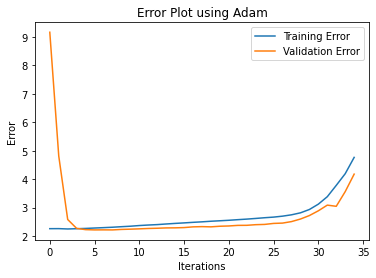

y_test :  [0 1 1 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 1 0 0 1 0 1
 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 1 0]
y_pred :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
BER :  0.515625
Accuracy on all test dataset : 0.0


In [143]:
index_pred = 0
evals_clf(clf_big, X_test, y_test, index_pred, opti, train_err_clf_big, val_err_clf_big)

### With selu activation

In [159]:
optimizer = Adagrad()
opti = 'Adagrad'
n_features = X_train.shape[1]
n_output = y_train.shape[1]
clf_sm = NeuralNetwork(optimizer=optimizer,
                        loss=MSE,
                        validation_data=(X_test, y_test))

In [160]:
clf_sm.add(Dense(512, input_shape=(n_features,)))
clf_sm.add(Activation('selu'))
clf_sm.add(BatchNormalization())

clf_sm.add(Dense(256))
clf_sm.add(Activation('selu'))
clf_sm.add(Dropout(0.25))
clf_sm.add(BatchNormalization())

clf_sm.add(Dense(128))
clf_sm.add(Activation('selu'))
clf_sm.add(Dropout(0.25))
clf_sm.add(BatchNormalization())

clf_sm.add(Dense(256))
clf_sm.add(Activation('selu'))
clf_sm.add(Dropout(0.25))
clf_sm.add(BatchNormalization())

clf_sm.add(Dense(n_output))
clf_sm.add(Activation('softmax'))

print ()
clf_sm.summary(name="Bits-To-Bits model")


+--------------------+
| Bits-To-Bits model |
+--------------------+
Input Shape: (64,)
+----------------------+------------+--------------+
| Layer Type           | Parameters | Output Shape |
+----------------------+------------+--------------+
| Dense                | 33280      | (512,)       |
| Activation (ELU)     | 0          | (512,)       |
| BatchNormalization   | 1024       | (512,)       |
| Dense                | 131328     | (256,)       |
| Activation (ELU)     | 0          | (256,)       |
| Dropout              | 0          | (256,)       |
| BatchNormalization   | 512        | (256,)       |
| Dense                | 32896      | (128,)       |
| Activation (ELU)     | 0          | (128,)       |
| Dropout              | 0          | (128,)       |
| BatchNormalization   | 256        | (128,)       |
| Dense                | 33024      | (256,)       |
| Activation (ELU)     | 0          | (256,)       |
| Dropout              | 0          | (256,)       |
| BatchNor

In [155]:
batch_size = 256
epochs = 35

In [156]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", epochs)
train_err_clf_sm, val_err_clf_sm = clf_sm.fit(X_train, y_train, n_epochs=epochs, batch_size=batch_size)

[INFO] Batch size :  256
[INFO] Training epochs number :  35


[INFO] Training loss on epoch  1  :  2.22166
[INFO] Validation loss on epoch  1  :  8.78618
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  2  :  2.19550
[INFO] Validation loss on epoch  2  :  3.06824
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  3  :  2.20317
[INFO] Validation loss on epoch  3  :  2.29689
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  4  :  2.21346
[INFO] Validation loss on epoch  4  :  2.18391
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  5  :  2.22126
[INFO] Validation loss on epoch  5  :  2.15172
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  6  :  2.23284
[INFO] Validation loss on epoch  6  :  2.14887
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  7  :  2.24481
[INFO] Validation loss on epoch  7  :  2.14554
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  8  :  2.25951
[INFO] Validation loss on epoch  8  :  2.15442
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  9  :  2.27132
[INFO] Validation loss on epoch  9  :  2.16046
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  10  :  2.28437
[INFO] Validation loss on epoch  10  :  2.16378
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  11  :  2.29790
[INFO] Validation loss on epoch  11  :  2.17294
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  12  :  2.30868
[INFO] Validation loss on epoch  12  :  2.17667
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  13  :  2.32089
[INFO] Validation loss on epoch  13  :  2.18399
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  14  :  2.33338
[INFO] Validation loss on epoch  14  :  2.18772
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  15  :  2.34600
[INFO] Validation loss on epoch  15  :  2.19702
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  16  :  2.35812
[INFO] Validation loss on epoch  16  :  2.19971
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  17  :  2.37033
[INFO] Validation loss on epoch  17  :  2.20639
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  18  :  2.38323
[INFO] Validation loss on epoch  18  :  2.21111
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  19  :  2.39484
[INFO] Validation loss on epoch  19  :  2.21606
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  20  :  2.40749
[INFO] Validation loss on epoch  20  :  2.22375
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  21  :  2.41684
[INFO] Validation loss on epoch  21  :  2.22690
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  22  :  2.42914
[INFO] Validation loss on epoch  22  :  2.23770
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  23  :  2.44149
[INFO] Validation loss on epoch  23  :  2.23736
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  24  :  2.45417
[INFO] Validation loss on epoch  24  :  2.24221
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  25  :  2.46638
[INFO] Validation loss on epoch  25  :  2.26583
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  26  :  2.47557
[INFO] Validation loss on epoch  26  :  2.26504
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  27  :  2.48582
[INFO] Validation loss on epoch  27  :  2.26218
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  28  :  2.49832
[INFO] Validation loss on epoch  28  :  2.26851
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  29  :  2.50594
[INFO] Validation loss on epoch  29  :  2.27157
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  30  :  2.51733
[INFO] Validation loss on epoch  30  :  2.27873
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  31  :  2.52800
[INFO] Validation loss on epoch  31  :  2.28333
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  32  :  2.53683
[INFO] Validation loss on epoch  32  :  2.28576
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  33  :  2.54732
[INFO] Validation loss on epoch  33  :  2.28214
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  34  :  2.55435
[INFO] Validation loss on epoch  34  :  2.28979
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  35  :  2.56337
[INFO] Validation loss on epoch  35  :  2.29903
-------------------------------------------------------------------------------


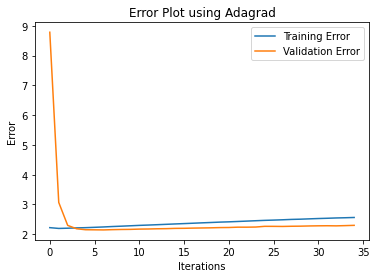

y_test :  [0 1 1 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 1 0 0 1 0 1
 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 1 0]
y_pred :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
BER :  0.515625
Accuracy on all test dataset : 0.3022


In [157]:
index_pred = 0
evals_clf(clf_sm, X_test, y_test, index_pred, opti, train_err_clf_sm, val_err_clf_sm)

## With ELU activation

### Adagrad

In [164]:
optimizer = Adagrad()
opti = 'Adagrad'
n_features = X_train.shape[1]
n_output = y_train.shape[1]
clf_sm_elu = NeuralNetwork(optimizer=optimizer,
                        loss=CrossEntropy,
                        validation_data=(X_test, y_test))

In [165]:
clf_sm_elu.add(Dense(512, input_shape=(n_features,)))
clf_sm_elu.add(Activation('elu'))
clf_sm_elu.add(BatchNormalization())

clf_sm_elu.add(Dense(256))
clf_sm_elu.add(Activation('elu'))
clf_sm_elu.add(Dropout(0.25))
clf_sm_elu.add(BatchNormalization())

clf_sm_elu.add(Dense(128))
clf_sm_elu.add(Activation('elu'))
clf_sm_elu.add(Dropout(0.25))
clf_sm_elu.add(BatchNormalization())

clf_sm_elu.add(Dense(256))
clf_sm_elu.add(Activation('elu'))
clf_sm_elu.add(Dropout(0.25))
clf_sm_elu.add(BatchNormalization())

clf_sm_elu.add(Dense(n_output))
clf_sm_elu.add(Activation('softmax'))

print ()
clf_sm_elu.summary(name="Bits-To-Bits model")


+--------------------+
| Bits-To-Bits model |
+--------------------+
Input Shape: (64,)
+----------------------+------------+--------------+
| Layer Type           | Parameters | Output Shape |
+----------------------+------------+--------------+
| Dense                | 33280      | (512,)       |
| Activation (ELU)     | 0          | (512,)       |
| BatchNormalization   | 1024       | (512,)       |
| Dense                | 131328     | (256,)       |
| Activation (ELU)     | 0          | (256,)       |
| Dropout              | 0          | (256,)       |
| BatchNormalization   | 512        | (256,)       |
| Dense                | 32896      | (128,)       |
| Activation (ELU)     | 0          | (128,)       |
| Dropout              | 0          | (128,)       |
| BatchNormalization   | 256        | (128,)       |
| Dense                | 33024      | (256,)       |
| Activation (ELU)     | 0          | (256,)       |
| Dropout              | 0          | (256,)       |
| BatchNor

In [166]:
batch_size = 256
epochs = 35

In [161]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", epochs)
train_err_clf_sm, val_err_clf_sm = clf_sm.fit(X_train, y_train, n_epochs=epochs, batch_size=batch_size)

[INFO] Batch size :  256
[INFO] Training epochs number :  35


[INFO] Training loss on epoch  1  :  0.00192
[INFO] Validation loss on epoch  1  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  2  :  0.00193
[INFO] Validation loss on epoch  2  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  3  :  0.00193
[INFO] Validation loss on epoch  3  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  4  :  0.00193
[INFO] Validation loss on epoch  4  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  5  :  0.00193
[INFO] Validation loss on epoch  5  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  6  :  0.00193
[INFO] Validation loss on epoch  6  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  7  :  0.00193
[INFO] Validation loss on epoch  7  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  8  :  0.00193
[INFO] Validation loss on epoch  8  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  9  :  0.00193
[INFO] Validation loss on epoch  9  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  10  :  0.00193
[INFO] Validation loss on epoch  10  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  11  :  0.00193
[INFO] Validation loss on epoch  11  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  12  :  0.00193
[INFO] Validation loss on epoch  12  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  13  :  0.00193
[INFO] Validation loss on epoch  13  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  14  :  0.00193
[INFO] Validation loss on epoch  14  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  15  :  0.00193
[INFO] Validation loss on epoch  15  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  16  :  0.00193
[INFO] Validation loss on epoch  16  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  17  :  0.00193
[INFO] Validation loss on epoch  17  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  18  :  0.00193
[INFO] Validation loss on epoch  18  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  19  :  0.00193
[INFO] Validation loss on epoch  19  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  20  :  0.00193
[INFO] Validation loss on epoch  20  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  21  :  0.00193
[INFO] Validation loss on epoch  21  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  22  :  0.00193
[INFO] Validation loss on epoch  22  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  23  :  0.00193
[INFO] Validation loss on epoch  23  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  24  :  0.00193
[INFO] Validation loss on epoch  24  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  25  :  0.00193
[INFO] Validation loss on epoch  25  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  26  :  0.00193
[INFO] Validation loss on epoch  26  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  27  :  0.00192
[INFO] Validation loss on epoch  27  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  28  :  0.00192
[INFO] Validation loss on epoch  28  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  29  :  0.00192
[INFO] Validation loss on epoch  29  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  30  :  0.00192
[INFO] Validation loss on epoch  30  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  31  :  0.00192
[INFO] Validation loss on epoch  31  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  32  :  0.00192
[INFO] Validation loss on epoch  32  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  33  :  0.00192
[INFO] Validation loss on epoch  33  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  34  :  0.00192
[INFO] Validation loss on epoch  34  :  0.00010
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  35  :  0.00192
[INFO] Validation loss on epoch  35  :  0.00010
-------------------------------------------------------------------------------


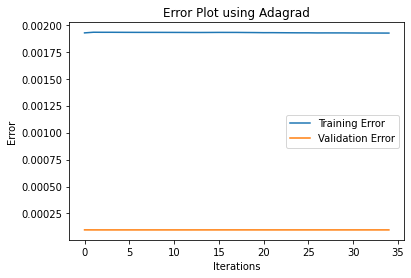

y_test :  [0 1 1 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 1 0 0 1 0 1
 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 1 0]
y_pred :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
BER :  0.515625
Accuracy on all test dataset : 0.3022


In [163]:
index_pred = 0
evals_clf(clf_sm, X_test, y_test, index_pred, opti, train_err_clf_sm, val_err_clf_sm)

### Stochastic Gradient Descent

In [169]:
optimizer = StochasticGradientDescent()
opti = 'Stochastic Gradient Descent'
n_features = X_train.shape[1]
n_output = y_train.shape[1]
clf_sm_elu = NeuralNetwork(optimizer=optimizer,
                        loss=CrossEntropy,
                        validation_data=(X_test, y_test))

In [170]:
clf_sm_elu.add(Dense(512, input_shape=(n_features,)))
clf_sm_elu.add(Activation('elu'))
clf_sm_elu.add(BatchNormalization())

clf_sm_elu.add(Dense(256))
clf_sm_elu.add(Activation('elu'))
clf_sm_elu.add(Dropout(0.25))
clf_sm_elu.add(BatchNormalization())

clf_sm_elu.add(Dense(128))
clf_sm_elu.add(Activation('elu'))
clf_sm_elu.add(Dropout(0.25))
clf_sm_elu.add(BatchNormalization())

clf_sm_elu.add(Dense(256))
clf_sm_elu.add(Activation('elu'))
clf_sm_elu.add(Dropout(0.25))
clf_sm_elu.add(BatchNormalization())

clf_sm_elu.add(Dense(n_output))
clf_sm_elu.add(Activation('softmax'))

print ()
clf_sm_elu.summary(name="Bits-To-Bits model")


+--------------------+
| Bits-To-Bits model |
+--------------------+
Input Shape: (64,)
+----------------------+------------+--------------+
| Layer Type           | Parameters | Output Shape |
+----------------------+------------+--------------+
| Dense                | 33280      | (512,)       |
| Activation (ELU)     | 0          | (512,)       |
| BatchNormalization   | 1024       | (512,)       |
| Dense                | 131328     | (256,)       |
| Activation (ELU)     | 0          | (256,)       |
| Dropout              | 0          | (256,)       |
| BatchNormalization   | 512        | (256,)       |
| Dense                | 32896      | (128,)       |
| Activation (ELU)     | 0          | (128,)       |
| Dropout              | 0          | (128,)       |
| BatchNormalization   | 256        | (128,)       |
| Dense                | 33024      | (256,)       |
| Activation (ELU)     | 0          | (256,)       |
| Dropout              | 0          | (256,)       |
| BatchNor

In [ ]:
batch_size = 256
epochs = 35

In [171]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", epochs)
train_err_clf_sm_elu, val_err_clf_sm_elu = clf_sm_elu.fit(X_train, y_train, n_epochs=epochs, batch_size=batch_size)

[INFO] Batch size :  256
[INFO] Training epochs number :  35


C:/Users/admin/Desktop/IP Paris/MICAS/Cours/910/913 - Deep Learning/Project\networks\activation_functions.py:48: RuntimeWarning: overflow encountered in exp
  return np.where(x >= 0.0, x, self.alpha * (np.exp(x) - 1))


[INFO] Training loss on epoch  1  :  16.57945
[INFO] Validation loss on epoch  1  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  2  :  17.24889
[INFO] Validation loss on epoch  2  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  3  :  17.24889
[INFO] Validation loss on epoch  3  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  4  :  17.24889
[INFO] Validation loss on epoch  4  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  5  :  17.24889
[INFO] Validation loss on epoch  5  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  6  :  17.24889
[INFO] Validation loss on epoch  6  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  7  :  17.24889
[INFO] Validation loss on epoch  7  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  8  :  17.24889
[INFO] Validation loss on epoch  8  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  9  :  17.24889
[INFO] Validation loss on epoch  9  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  10  :  17.24889
[INFO] Validation loss on epoch  10  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  11  :  17.24889
[INFO] Validation loss on epoch  11  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  12  :  17.24889
[INFO] Validation loss on epoch  12  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  13  :  17.24889
[INFO] Validation loss on epoch  13  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  14  :  17.24889
[INFO] Validation loss on epoch  14  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  15  :  17.24889
[INFO] Validation loss on epoch  15  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  16  :  17.24889
[INFO] Validation loss on epoch  16  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  17  :  17.24889
[INFO] Validation loss on epoch  17  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  18  :  17.24889
[INFO] Validation loss on epoch  18  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  19  :  17.24889
[INFO] Validation loss on epoch  19  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  20  :  17.24889
[INFO] Validation loss on epoch  20  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  21  :  17.24889
[INFO] Validation loss on epoch  21  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  22  :  17.24889
[INFO] Validation loss on epoch  22  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  23  :  17.24889
[INFO] Validation loss on epoch  23  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  24  :  17.24889
[INFO] Validation loss on epoch  24  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  25  :  17.24889
[INFO] Validation loss on epoch  25  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  26  :  17.24889
[INFO] Validation loss on epoch  26  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  27  :  17.24889
[INFO] Validation loss on epoch  27  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  28  :  17.24889
[INFO] Validation loss on epoch  28  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  29  :  17.24889
[INFO] Validation loss on epoch  29  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  30  :  17.24889
[INFO] Validation loss on epoch  30  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  31  :  17.24889
[INFO] Validation loss on epoch  31  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  32  :  17.24889
[INFO] Validation loss on epoch  32  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  33  :  17.24889
[INFO] Validation loss on epoch  33  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  34  :  17.24889
[INFO] Validation loss on epoch  34  :  17.26465
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  35  :  17.24889
[INFO] Validation loss on epoch  35  :  17.26465
-------------------------------------------------------------------------------


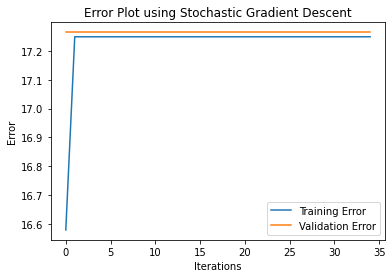

y_test :  [0 1 1 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 1 0 0 1 0 1
 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 1 0]
y_pred :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
BER :  0.5
Accuracy on all test dataset : 0.3022


In [172]:
index_pred = 0
evals_clf(clf_sm_elu, X_test, y_test, index_pred, opti, train_err_clf_sm_elu, val_err_clf_sm_elu)